In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import torch
from tqdm.auto import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import re
import torch.utils.data as data
from dataclasses import dataclass
import pandas as pd

from fuzzywuzzy import process
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter


from avae.model import AttentionVae, GPTConfig
from avae.dataset import CharDataset
from avae.trainer import TrainerConfig, Trainer
from avae.utils import pad_word, depad_word, encode_word, decode_word
from avae.utils import generate_samples
writer = SummaryWriter('runs/avae')

/home/simon/anaconda3/envs/namegen/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
PROJECT_DIR  = Path(".").resolve().parent.parent
DATA_DIR  = PROJECT_DIR / "data"
WIKI_DIR  = DATA_DIR / "wikitext-2"
NAMES_DIR  = DATA_DIR / "names"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def clean_word(word):
    word = word.replace("\n", '').lower()
    return word

# Sample Generation

In [4]:
def print_generation(
    model,
    unique_train_words=None,
    context="",
    method="smart",
    sample=False,
    top_k=5,
    temperature=1.0,
):

    print(f"Context: {context}")
    samples = generate_samples(
        model,
        n_samples=50,
        initial_context=context,
        method=method,
        sample=sample,
        top_k=top_k,
        temperature=temperature,
    )
    samples = list(set(samples))
    for sample in samples:

        if unique_train_words:
            match = process.extract(sample, unique_train_words, limit=1)[0][0]
            sample += " " * (20 - len(sample))
            sample += f"\t\t closest match: {match}"
        print(sample)
    print()


def generation_testing(
    model,
    unique_train_words=None,
    method="smart",
    sample=False,
    top_k=5,
    temperature=1.0,
):
    print_generation(
        model,
        unique_train_words=unique_train_words,
        method=method,
        sample=sample,
        top_k=top_k,
        temperature=temperature,
    )
    print_generation(
        model,
        context="a",
        unique_train_words=unique_train_words,
        method=method,
        sample=sample,
        top_k=top_k,
        temperature=temperature,
    )
    print_generation(
        model,
        context="m",
        unique_train_words=unique_train_words,
        method=method,
        sample=sample,
        top_k=top_k,
        temperature=temperature,
    )
    print_generation(
        model,
        context="sim",
        unique_train_words=unique_train_words,
        method=method,
        sample=sample,
        top_k=top_k,
        temperature=temperature,
    )

# Experiments

## Transfer wiki weights

In [5]:
NAMES_DIR / "french_names_no_accent.txt"

PosixPath('/home/simon/code/namegen/data/names/french_names_no_accent.txt')

In [6]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
wiki_vae = AttentionVae.load("wiki_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

wiki_vae = AttentionVae.load("wiki_model")
chars = list(wiki_vae.stoi.keys())
maxlen = wiki_vae.config.block_size

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), wiki_vae.itos))
print("y: ",decode_word(y.numpy(), wiki_vae.itos))
print("word :", decode_word(word.numpy(), wiki_vae.itos))

tconf = TrainerConfig(
    max_epochs=30,
    batch_size=256,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000
)
trainer = Trainer(wiki_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()


data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


  0%|          | 0/135 [00:00<?, ?it/s]/home/simon/code/namegen/avae/src/avae/trainer.py:123: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  self.model.parameters(), self.config.grad_norm_clip
epoch 1) iter 0: train_loss 220.7916718, lr = 5.999922e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: flowlern                  	 closes match: lo 
Sample: decie                     	 closes match: aldecine 
Sample: narrelber                 	 closes match: bert 
Sample: needaliesy                	 closes match: ed 


epoch 1) iter 2: train_loss 221.2610474, lr = 5.998594e-04:   2%|▏         | 3/135 [00:03<05:20,  2.43s/it]

Sample: the                       	 closes match: therence 


epoch 1) iter 134: train_loss 218.9756775, lr = 3.006754e-04: 100%|██████████| 135/135 [00:14<00:00,  9.20it/s]


Test loss: 218.26083170572917


epoch 2) iter 0: train_loss 218.3218994, lr = 2.971632e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nathony                   	 closes match: anthony 
Sample: yan                       	 closes match: leyana 
Sample: elleande                  	 closes match: lea 
Sample: ing                       	 closes match: ingrid 


epoch 2) iter 2: train_loss 218.4370880, lr = 2.901402e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: annin                     	 closes match: ioannina 


epoch 2) iter 134: train_loss 218.5994415, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.86it/s]


Test loss: 218.13052368164062


epoch 3) iter 0: train_loss 218.7027588, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ned                       	 closes match: ned 
Sample: stelline                  	 closes match: stellie 
Sample: invian                    	 closes match: ian 
Sample: leona                     	 closes match: leona 


epoch 3) iter 2: train_loss 217.5560608, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: maelel                    	 closes match: mae 


epoch 3) iter 134: train_loss 218.4492188, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00,  9.90it/s]


Test loss: 218.1812967936198


epoch 4) iter 0: train_loss 217.6675262, lr = 3.041876e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: angeline                  	 closes match: angeline 
Sample: maelisine                 	 closes match: mae 
Sample: zelonie                   	 closes match: lo 
Sample: egalanna                  	 closes match: anna 


epoch 4) iter 2: train_loss 218.7899170, lr = 3.112098e-04:   2%|▏         | 3/135 [00:02<03:59,  1.81s/it]

Sample: navemine                  	 closes match: aveline 


epoch 4) iter 134: train_loss 218.6969452, lr = 5.999970e-04: 100%|██████████| 135/135 [00:13<00:00,  9.70it/s]


Test loss: 218.18964335123698


epoch 5) iter 0: train_loss 218.3119507, lr = 5.999606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: neold                     	 closes match: neo 
Sample: mianne                    	 closes match: anne 
Sample: zefin                     	 closes match: zeline 
Sample: zephlie                   	 closes match: zephir 


epoch 5) iter 2: train_loss 218.6767731, lr = 5.997645e-04:   2%|▏         | 3/135 [00:02<03:24,  1.55s/it]

Sample: alexra                    	 closes match: alexa 


epoch 5) iter 134: train_loss 217.4093170, lr = 2.979737e-04: 100%|██████████| 135/135 [00:13<00:00, 10.07it/s]


Test loss: 218.0962361653646


epoch 6) iter 0: train_loss 217.9667969, lr = 2.944616e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gwena                     	 closes match: gwenaelle 
Sample: gwelvi                    	 closes match: elvis 
Sample: neved                     	 closes match: ed 
Sample: mabelin                   	 closes match: lin 


epoch 6) iter 2: train_loss 218.3614807, lr = 2.874403e-04:   2%|▏         | 3/135 [00:02<03:39,  1.66s/it]

Sample: evontaule                 	 closes match: von 


epoch 6) iter 134: train_loss 217.0786438, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.92it/s]


Test loss: 217.79851684570312


epoch 7) iter 0: train_loss 217.5374756, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: slaviran                  	 closes match: ira 
Sample: narcolla                  	 closes match: lyla 
Sample: zechrie                   	 closes match: zacharie 
Sample: malve                     	 closes match: malvine 


epoch 7) iter 2: train_loss 218.1988525, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:39,  1.66s/it]

Sample: neslined                  	 closes match: ed 


epoch 7) iter 134: train_loss 218.1073761, lr = 3.033772e-04: 100%|██████████| 135/135 [00:13<00:00,  9.87it/s]


Test loss: 217.91478678385417


epoch 8) iter 0: train_loss 217.8139343, lr = 3.068890e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zephy                     	 closes match: zephyr 
Sample: zegorine                  	 closes match: reine 
Sample: ezenogette                	 closes match: zeno 
Sample: englaine                  	 closes match: elaine 


epoch 8) iter 2: train_loss 217.8599091, lr = 3.139092e-04:   2%|▏         | 3/135 [00:02<03:51,  1.75s/it]

Sample: kelie                     	 closes match: elie 


epoch 8) iter 134: train_loss 218.2934875, lr = 5.999726e-04: 100%|██████████| 135/135 [00:13<00:00,  9.84it/s]


Test loss: 218.0759053548177


epoch 9) iter 0: train_loss 218.1365967, lr = 5.999046e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: norette                   	 closes match: nore 
Sample: yolline                   	 closes match: lin 
Sample: mheliane                  	 closes match: heliane 
Sample: nerette                   	 closes match: neree 


epoch 9) iter 2: train_loss 218.0005035, lr = 5.996453e-04:   2%|▏         | 3/135 [00:02<03:23,  1.55s/it]

Sample: naty                      	 closes match: bernat 


epoch 9) iter 134: train_loss 218.3702545, lr = 2.952721e-04: 100%|██████████| 135/135 [00:13<00:00, 10.02it/s]


Test loss: 217.8949198404948


epoch 10) iter 0: train_loss 218.3853149, lr = 2.917606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: genoma                    	 closes match: gena 
Sample: baudyne                   	 closes match: aude 
Sample: stalem                    	 closes match: stanley 
Sample: zephyn                    	 closes match: zephyrin 


epoch 10) iter 2: train_loss 217.7411041, lr = 2.847415e-04:   2%|▏         | 3/135 [00:02<03:14,  1.48s/it]

Sample: yanan                     	 closes match: ana 


epoch 10) iter 134: train_loss 217.1949158, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.92it/s]


Test loss: 217.801313273112


epoch 11) iter 0: train_loss 217.3521881, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ysan                      	 closes match: chrysante 
Sample: azixende                  	 closes match: des 
Sample: kelmenti                  	 closes match: belen 
Sample: anour                     	 closes match: ano 


epoch 11) iter 2: train_loss 217.5325165, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: yec'har                   	 closes match: yec'han 


epoch 11) iter 134: train_loss 218.2197266, lr = 3.060786e-04: 100%|██████████| 135/135 [00:13<00:00,  9.81it/s]


Test loss: 217.91497294108072


epoch 12) iter 0: train_loss 217.5697021, lr = 3.095897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aubertus                  	 closes match: bert 
Sample: lauran                    	 closes match: laurane 
Sample: stefan                    	 closes match: stefania 
Sample: zean                      	 closes match: zerane 


epoch 12) iter 2: train_loss 217.7908478, lr = 3.166075e-04:   2%|▏         | 3/135 [00:02<03:51,  1.76s/it]

Sample: menricio                  	 closes match: enric 


epoch 12) iter 134: train_loss 217.9845886, lr = 5.999240e-04: 100%|██████████| 135/135 [00:13<00:00,  9.77it/s]


Test loss: 218.1065226236979


epoch 13) iter 0: train_loss 217.7944031, lr = 5.998243e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: naemitan                  	 closes match: naemi 
Sample: matietsique               	 closes match: mati 
Sample: gwiller                   	 closes match: gwilherm 
Sample: leopoul                   	 closes match: leo 


epoch 13) iter 2: train_loss 217.6944275, lr = 5.995018e-04:   2%|▏         | 3/135 [00:02<04:15,  1.94s/it]

Sample: androgoin                 	 closes match: sandro 


epoch 13) iter 134: train_loss 217.9440918, lr = 2.925708e-04: 100%|██████████| 135/135 [00:13<00:00,  9.68it/s]


Test loss: 217.83063151041668


epoch 14) iter 0: train_loss 217.6002350, lr = 2.890602e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: kerie                     	 closes match: kerrien 
Sample: neodona                   	 closes match: odon 
Sample: standy                    	 closes match: sandy 
Sample: nelle                     	 closes match: noelle 


epoch 14) iter 2: train_loss 217.7720032, lr = 2.820438e-04:   2%|▏         | 3/135 [00:02<03:15,  1.48s/it]

Sample: neigle                    	 closes match: neige 


epoch 14) iter 134: train_loss 217.1486511, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.19it/s]


Test loss: 217.766645304362


epoch 15) iter 0: train_loss 216.9766541, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maysimo                   	 closes match: may 
Sample: yoelle                    	 closes match: yoelle 
Sample: necise                    	 closes match: isea 
Sample: yvaque                    	 closes match: symmaque 


epoch 15) iter 2: train_loss 217.3430176, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:10,  1.44s/it]

Sample: enseria                   	 closes match: genseric 


epoch 15) iter 134: train_loss 217.3452148, lr = 3.087796e-04: 100%|██████████| 135/135 [00:13<00:00, 10.06it/s]


Test loss: 217.86304728190103


epoch 16) iter 0: train_loss 218.0154419, lr = 3.122897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: angelo                    	 closes match: angelo 
Sample: natel                     	 closes match: donatella 
Sample: natelia                   	 closes match: natelia 
Sample: zephita                   	 closes match: ita 


epoch 16) iter 2: train_loss 216.9405823, lr = 3.193045e-04:   2%|▏         | 3/135 [00:02<03:20,  1.52s/it]

Sample: salain                    	 closes match: salaun 


epoch 16) iter 134: train_loss 216.8181152, lr = 5.998510e-04: 100%|██████████| 135/135 [00:13<00:00, 10.13it/s]


Test loss: 217.9780039469401


epoch 17) iter 0: train_loss 217.4635010, lr = 5.997197e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nelithen                  	 closes match: neith 
Sample: yessandrin                	 closes match: sandrine 
Sample: melane                    	 closes match: melane 
Sample: nadogyle                  	 closes match: lee 


epoch 17) iter 2: train_loss 218.1757202, lr = 5.993340e-04:   2%|▏         | 3/135 [00:02<03:57,  1.80s/it]

Sample: mateus                    	 closes match: amadeus 


epoch 17) iter 134: train_loss 217.7375488, lr = 2.898702e-04: 100%|██████████| 135/135 [00:13<00:00,  9.86it/s]


Test loss: 217.90231424967448


epoch 18) iter 0: train_loss 217.0883484, lr = 2.863607e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nela                      	 closes match: nella 
Sample: stella                    	 closes match: stella 
Sample: yarenolde                 	 closes match: arnold 
Sample: naet                      	 closes match: naudet 


epoch 18) iter 2: train_loss 217.5474396, lr = 2.793476e-04:   2%|▏         | 3/135 [00:02<04:21,  1.98s/it]

Sample: neline                    	 closes match: noeline 


epoch 18) iter 134: train_loss 216.7359467, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.67it/s]


Test loss: 217.6943806966146


epoch 19) iter 0: train_loss 217.2783966, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zelene                    	 closes match: elenie 
Sample: naric                     	 closes match: enric 
Sample: nestine                   	 closes match: ernestine 
Sample: yvonnie                   	 closes match: yvonne 


epoch 19) iter 2: train_loss 217.0522461, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:32,  1.61s/it]

Sample: zephieren                 	 closes match: zephir 


epoch 19) iter 134: train_loss 216.9453583, lr = 3.114798e-04: 100%|██████████| 135/135 [00:13<00:00, 10.03it/s]


Test loss: 217.75411580403645


epoch 20) iter 0: train_loss 217.6329346, lr = 3.149887e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nevela                    	 closes match: neela 
Sample: lana                      	 closes match: lana 
Sample: agloume                   	 closes match: lo 
Sample: zian                      	 closes match: zian 


epoch 20) iter 2: train_loss 217.5253143, lr = 3.219998e-04:   2%|▏         | 3/135 [00:02<03:47,  1.73s/it]

Sample: staninke                  	 closes match: stan 


epoch 20) iter 134: train_loss 217.1669464, lr = 5.997537e-04: 100%|██████████| 135/135 [00:13<00:00,  9.93it/s]


Test loss: 217.95797729492188


epoch 21) iter 0: train_loss 217.2737122, lr = 5.995908e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leocian                   	 closes match: ian 
Sample: nadie                     	 closes match: nadine 
Sample: keony                     	 closes match: kenya 
Sample: neudele                   	 closes match: nedeleg 


epoch 21) iter 2: train_loss 217.1567078, lr = 5.991420e-04:   2%|▏         | 3/135 [00:02<03:21,  1.53s/it]

Sample: kesildes                  	 closes match: des 


epoch 21) iter 134: train_loss 217.4804230, lr = 2.871704e-04: 100%|██████████| 135/135 [00:13<00:00, 10.15it/s]


Test loss: 217.74689534505208


epoch 22) iter 0: train_loss 217.3859253, lr = 2.836622e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: micherios                 	 closes match: michee 
Sample: zefier                    	 closes match: elfie 
Sample: ilea                      	 closes match: ilea 
Sample: nantivis                  	 closes match: ivi 


epoch 22) iter 2: train_loss 217.3110809, lr = 2.766531e-04:   2%|▏         | 3/135 [00:03<04:27,  2.03s/it]

Sample: naredanice                	 closes match: ed 


epoch 22) iter 134: train_loss 218.1509399, lr = 6.000000e-05: 100%|██████████| 135/135 [00:14<00:00,  9.61it/s]


Test loss: 217.64187418619792


epoch 23) iter 0: train_loss 216.8130188, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nan                       	 closes match: venance 
Sample: gaude                     	 closes match: gauderique 
Sample: myrie                     	 closes match: myriem 
Sample: yeron                     	 closes match: tyron 


epoch 23) iter 2: train_loss 216.6894226, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:39,  1.67s/it]

Sample: meneha                    	 closes match: enea 


epoch 23) iter 134: train_loss 217.9483337, lr = 3.141791e-04: 100%|██████████| 135/135 [00:13<00:00, 10.00it/s]


Test loss: 217.84666239420574


epoch 24) iter 0: train_loss 217.3837280, lr = 3.176865e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: laio                      	 closes match: flavio 
Sample: nerekald                  	 closes match: kal 
Sample: zenon                     	 closes match: zenon 
Sample: yec'in                    	 closes match: yec'han 


epoch 24) iter 2: train_loss 217.2145081, lr = 3.246934e-04:   2%|▏         | 3/135 [00:02<03:44,  1.70s/it]

Sample: lenguele                  	 closes match: elne 


epoch 24) iter 134: train_loss 217.1254883, lr = 5.996320e-04: 100%|██████████| 135/135 [00:13<00:00,  9.96it/s]


Test loss: 217.89258626302083


epoch 25) iter 0: train_loss 217.2782288, lr = 5.994376e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leonn                     	 closes match: leo 
Sample: malore                    	 closes match: malorie 
Sample: zepimi                    	 closes match: mei 
Sample: zenorea                   	 closes match: zeno 


epoch 25) iter 2: train_loss 217.6487122, lr = 5.989256e-04:   2%|▏         | 3/135 [00:02<03:37,  1.65s/it]

Sample: mathairic                 	 closes match: rioc 


epoch 25) iter 134: train_loss 217.0096588, lr = 2.844716e-04: 100%|██████████| 135/135 [00:13<00:00, 10.01it/s]


Test loss: 217.88072713216147


epoch 26) iter 0: train_loss 217.4203796, lr = 2.809652e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: menia                     	 closes match: mencia 
Sample: enryso                    	 closes match: emrys 
Sample: mabaldy                   	 closes match: magaly 
Sample: nevelin                   	 closes match: lin 


epoch 26) iter 2: train_loss 217.0479126, lr = 2.739605e-04:   2%|▏         | 3/135 [00:02<03:36,  1.64s/it]

Sample: alithelina                	 closes match: lin 


epoch 26) iter 134: train_loss 217.3334961, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.04it/s]


Test loss: 217.67878011067708


epoch 27) iter 0: train_loss 217.1554871, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ysensia                   	 closes match: ysens 
Sample: meza                      	 closes match: meal 
Sample: zlesline                  	 closes match: lin 
Sample: mava                      	 closes match: maeva 


epoch 27) iter 2: train_loss 217.2307281, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<04:01,  1.83s/it]

Sample: neissicka                 	 closes match: nessie 


epoch 27) iter 134: train_loss 217.1271515, lr = 3.168773e-04: 100%|██████████| 135/135 [00:13<00:00,  9.83it/s]


Test loss: 217.83332112630208


epoch 28) iter 0: train_loss 217.1025238, lr = 3.203828e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: yannin                    	 closes match: ann 
Sample: neador                    	 closes match: dora 
Sample: nestole                   	 closes match: nestor 
Sample: gwolfred                  	 closes match: ed 


epoch 28) iter 2: train_loss 217.3390503, lr = 3.273850e-04:   2%|▏         | 3/135 [00:02<03:14,  1.48s/it]

Sample: nerdy                     	 closes match: ned 


epoch 28) iter 134: train_loss 216.6953583, lr = 5.994861e-04: 100%|██████████| 135/135 [00:13<00:00, 10.20it/s]


Test loss: 218.01659240722657


epoch 29) iter 0: train_loss 217.0806274, lr = 5.992601e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zea                       	 closes match: lyzea 
Sample: ghenerie                  	 closes match: erine 
Sample: lena                      	 closes match: lena 
Sample: kemalio                   	 closes match: ali 


epoch 29) iter 2: train_loss 217.2879944, lr = 5.986851e-04:   2%|▏         | 3/135 [00:02<03:56,  1.79s/it]

Sample: nicia                     	 closes match: veronica 


epoch 29) iter 134: train_loss 217.7705383, lr = 2.817741e-04: 100%|██████████| 135/135 [00:13<00:00,  9.83it/s]


Test loss: 217.84669494628906


epoch 30) iter 0: train_loss 217.3622894, lr = 2.782696e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nega                      	 closes match: linnea 
Sample: nannella                  	 closes match: anne 
Sample: nesca                     	 closes match: nectan 
Sample: mahar                     	 closes match: macha 


epoch 30) iter 2: train_loss 217.3204956, lr = 2.712700e-04:   2%|▏         | 3/135 [00:02<04:03,  1.85s/it]

Sample: zaie                      	 closes match: zite 


epoch 30) iter 134: train_loss 217.2926483, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.76it/s]


Test loss: 217.75897521972655


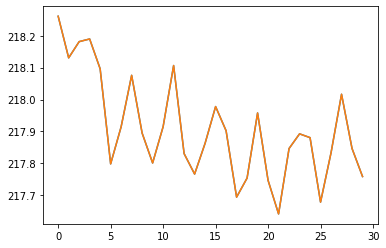

In [7]:
plt.plot(losses['test_loss'])

In [8]:
generation_testing(wiki_vae, train_dataset.unique_word_list)

Context: 
zenobine		 closest match: zenobin
lauren		 closest match: lauren
zaida		 closest match: zaida
nelle		 closest match: noelle
mathieu		 closest match: mathieu
malissa		 closest match: alis
leonick		 closest match: nick
salvine		 closest match: salvine
noelle		 closest match: noelle
gwenny		 closest match: gwennyn
melissa		 closest match: melissa
nathana		 closest match: nathan
maeline		 closest match: maeline
mahilde		 closest match: mathilde
maloue		 closest match: maloe
lyana		 closest match: lyana
geneva		 closest match: geneva
leona		 closest match: leona
placide		 closest match: placide

Context: a
antonine		 closest match: antonine
arnoul		 closest match: arnoult
aigna		 closest match: aignan
angeline		 closest match: angeline
antonia		 closest match: antonia
antonie		 closest match: antonine
alissa		 closest match: aissa
azilia		 closest match: lia
aina		 closest match: uhaina
aubert		 closest match: aubert

Context: m
mallon		 closest match: lo
maloria		 closest match: 

## Transfer wiki weights, freeze encoder

In [9]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
frozen_wiki_vae = AttentionVae.load("wiki_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), frozen_wiki_vae.itos))
print("y: ",decode_word(y.numpy(), frozen_wiki_vae.itos))
print("word :", decode_word(word.numpy(), frozen_wiki_vae.itos))

frozen_list = []
for par in frozen_wiki_vae.named_parameters():
    if "encoder" in par[0]:
        frozen_list.append(par[0])

frozen_wiki_vae = AttentionVae.load("wiki_model")
chars = list(frozen_wiki_vae.stoi.keys())
maxlen = frozen_wiki_vae.config.block_size

tconf = TrainerConfig(
    max_epochs=20,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000,
    freeze_layers=tuple(frozen_list)
)
trainer = Trainer(frozen_wiki_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


epoch 1) iter 0: train_loss 220.8602295, lr = 5.999997e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: negagant                  	 closes match: ganet 
Sample: namet                     	 closes match: ame 
Sample: engine                    	 closes match: regine 
Sample: trades                    	 closes match: des 


epoch 1) iter 4: train_loss 219.0007019, lr = 5.999080e-04:   1%|▏         | 4/269 [00:02<06:43,  1.52s/it]

Sample: engroub                   	 closes match: ruby 


epoch 1) iter 268: train_loss 218.9481659, lr = 3.006754e-04: 100%|██████████| 269/269 [00:14<00:00, 18.09it/s]


Test loss: 218.1620320638021


epoch 2) iter 0: train_loss 217.7460480, lr = 2.989193e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nea                       	 closes match: linnea 
Sample: steba                     	 closes match: esteban 
Sample: arnescon                  	 closes match: agnes 
Sample: gartreate                 	 closes match: ted 


epoch 2) iter 4: train_loss 218.6791992, lr = 2.918956e-04:   1%|▏         | 4/269 [00:02<08:02,  1.82s/it]

Sample: remanim                   	 closes match: remi 


epoch 2) iter 268: train_loss 219.1162109, lr = 6.000000e-05: 100%|██████████| 269/269 [00:15<00:00, 17.35it/s]


Test loss: 218.15076395670573


epoch 3) iter 0: train_loss 218.6708679, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: neeli                     	 closes match: neela 
Sample: rodvinetue                	 closes match: divine 
Sample: stee                      	 closes match: estee 
Sample: zaita                     	 closes match: ita 


epoch 3) iter 4: train_loss 217.8467102, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<08:19,  1.88s/it]

Sample: stef                      	 closes match: stefania 


epoch 3) iter 268: train_loss 218.1461945, lr = 3.006754e-04: 100%|██████████| 269/269 [00:15<00:00, 17.54it/s]


Test loss: 218.13929901123046


epoch 4) iter 0: train_loss 217.7527161, lr = 3.024316e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zeliana                   	 closes match: eliana 
Sample: anaa                      	 closes match: ana 
Sample: nesela                    	 closes match: neela 
Sample: tiffard                   	 closes match: if 


epoch 4) iter 4: train_loss 217.8399658, lr = 3.094547e-04:   1%|▏         | 4/269 [00:02<07:02,  1.59s/it]

Sample: zeo                       	 closes match: zeno 


epoch 4) iter 268: train_loss 218.6414948, lr = 5.999970e-04: 100%|██████████| 269/269 [00:14<00:00, 18.12it/s]


Test loss: 218.2060312906901


epoch 5) iter 0: train_loss 217.6034851, lr = 5.999839e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: queline                   	 closes match: lin 
Sample: maryliane                 	 closes match: maryline 
Sample: melia                     	 closes match: amelia 
Sample: nelle                     	 closes match: noelle 


epoch 5) iter 4: train_loss 219.2719116, lr = 5.998289e-04:   1%|▏         | 4/269 [00:02<07:41,  1.74s/it]

Sample: zan                       	 closes match: leozane 


epoch 5) iter 268: train_loss 217.8554230, lr = 2.979737e-04: 100%|██████████| 269/269 [00:15<00:00, 17.88it/s]


Test loss: 218.0008107503255


epoch 6) iter 0: train_loss 217.8459778, lr = 2.962176e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: neel                      	 closes match: neela 
Sample: nonestate                 	 closes match: nanette 
Sample: nectdes                   	 closes match: des 
Sample: naelitumon                	 closes match: ael 


epoch 6) iter 4: train_loss 218.3604584, lr = 2.891952e-04:   1%|▏         | 4/269 [00:02<08:36,  1.95s/it]

Sample: xena                      	 closes match: xenia 


epoch 6) iter 268: train_loss 217.4984283, lr = 6.000000e-05: 100%|██████████| 269/269 [00:15<00:00, 17.49it/s]


Test loss: 218.09083302815756


epoch 7) iter 0: train_loss 218.3238983, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nedich                    	 closes match: ed 
Sample: netteoua                  	 closes match: teo 
Sample: nestina                   	 closes match: tina 
Sample: nessae                    	 closes match: nessie 


epoch 7) iter 4: train_loss 217.6279907, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<06:38,  1.50s/it]

Sample: biane                     	 closes match: ian 


epoch 7) iter 268: train_loss 218.3194275, lr = 3.033772e-04: 100%|██████████| 269/269 [00:14<00:00, 18.23it/s]


Test loss: 217.9594512939453


epoch 8) iter 0: train_loss 217.7276306, lr = 3.051332e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ary                       	 closes match: maryanick 
Sample: naturiane                 	 closes match: ian 
Sample: nebaue                    	 closes match: aure 
Sample: zzeviuli                  	 closes match: lin 


epoch 8) iter 4: train_loss 218.0611420, lr = 3.121547e-04:   1%|▏         | 4/269 [00:02<07:59,  1.81s/it]

Sample: neso                      	 closes match: neo 


epoch 8) iter 268: train_loss 217.9177246, lr = 5.999726e-04: 100%|██████████| 269/269 [00:15<00:00, 17.76it/s]


Test loss: 218.0848653157552


epoch 9) iter 0: train_loss 217.4777069, lr = 5.999438e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: engeery                   	 closes match: englebert 
Sample: ayan                      	 closes match: layana 
Sample: eye                       	 closes match: cheyenne 
Sample: aubilis                   	 closes match: lis 


epoch 9) iter 4: train_loss 216.7560120, lr = 5.997255e-04:   1%|▏         | 4/269 [00:02<06:55,  1.57s/it]

Sample: aubine                    	 closes match: aubine 


epoch 9) iter 268: train_loss 217.2897034, lr = 2.952721e-04: 100%|██████████| 269/269 [00:14<00:00, 18.16it/s]


Test loss: 217.99720001220703


epoch 10) iter 0: train_loss 216.9292145, lr = 2.935162e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: renie                     	 closes match: rene 
Sample: yer                       	 closes match: yerri 
Sample: nelo                      	 closes match: lo 
Sample: baist                     	 closes match: baptiste 


epoch 10) iter 4: train_loss 217.7521057, lr = 2.864956e-04:   1%|▏         | 4/269 [00:02<07:31,  1.71s/it]

Sample: zacaid                    	 closes match: aida 


epoch 10) iter 268: train_loss 217.0716553, lr = 6.000000e-05: 100%|██████████| 269/269 [00:15<00:00, 17.88it/s]


Test loss: 217.78990122477214


epoch 11) iter 0: train_loss 218.1301270, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zacina                    	 closes match: inna 
Sample: nelia                     	 closes match: noelia 
Sample: nesia                     	 closes match: lesia 
Sample: zenobinie                 	 closes match: zeno 


epoch 11) iter 4: train_loss 217.4465942, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<07:28,  1.69s/it]

Sample: refienno                  	 closes match: nuno 


epoch 11) iter 268: train_loss 218.1206055, lr = 3.060786e-04: 100%|██████████| 269/269 [00:14<00:00, 17.97it/s]


Test loss: 217.93355458577474


epoch 12) iter 0: train_loss 217.3523254, lr = 3.078343e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: oebardis                  	 closes match: paris 
Sample: nathanala                 	 closes match: nathan 
Sample: rode                      	 closes match: rodene 
Sample: agbin                     	 closes match: gabin 


epoch 12) iter 4: train_loss 217.7868042, lr = 3.148538e-04:   1%|▏         | 4/269 [00:02<07:49,  1.77s/it]

Sample: ebgert                    	 closes match: egbert 


epoch 12) iter 268: train_loss 217.8317108, lr = 5.999240e-04: 100%|██████████| 269/269 [00:15<00:00, 17.80it/s]


Test loss: 218.0566884358724


epoch 13) iter 0: train_loss 218.1860199, lr = 5.998793e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leance                    	 closes match: leane 
Sample: zenon                     	 closes match: zenon 
Sample: lena                      	 closes match: lena 
Sample: anie                      	 closes match: stephanie 


epoch 13) iter 4: train_loss 218.2291565, lr = 5.995978e-04:   1%|▏         | 4/269 [00:02<07:43,  1.75s/it]

Sample: engebin                   	 closes match: ian 


epoch 13) iter 268: train_loss 217.1216278, lr = 2.925708e-04: 100%|██████████| 269/269 [00:15<00:00, 17.81it/s]


Test loss: 217.97213541666667


epoch 14) iter 0: train_loss 217.3477020, lr = 2.908153e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: benjar                    	 closes match: ben 
Sample: nelecia                   	 closes match: electa 
Sample: zlau                      	 closes match: laud 
Sample: redrica                   	 closes match: ed 


epoch 14) iter 4: train_loss 217.6526489, lr = 2.837971e-04:   1%|▏         | 4/269 [00:02<06:33,  1.49s/it]

Sample: naymon                    	 closes match: aymon 


epoch 14) iter 268: train_loss 218.0282745, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.27it/s]


Test loss: 217.87653605143228


epoch 15) iter 0: train_loss 216.6276550, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: nfaricie                  	 closes match: aricie 
Sample: mellanetic                	 closes match: ella 
Sample: zvise                     	 closes match: venise 
Sample: zenobod                   	 closes match: zeno 


epoch 15) iter 4: train_loss 217.0743713, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<07:46,  1.76s/it]

Sample: nela                      	 closes match: nella 


epoch 15) iter 268: train_loss 217.9205780, lr = 3.087796e-04: 100%|██████████| 269/269 [00:15<00:00, 17.80it/s]


Test loss: 217.92323557535806


epoch 16) iter 0: train_loss 217.2861786, lr = 3.105348e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: yana                      	 closes match: leyana 
Sample: anthere                   	 closes match: antere 
Sample: zerine                    	 closes match: erine 
Sample: nahoum                    	 closes match: nahum 


epoch 16) iter 4: train_loss 217.4909058, lr = 3.175516e-04:   1%|▏         | 4/269 [00:02<07:01,  1.59s/it]

Sample: zelion                    	 closes match: elio 


epoch 16) iter 268: train_loss 217.8935089, lr = 5.998510e-04: 100%|██████████| 269/269 [00:14<00:00, 18.06it/s]


Test loss: 217.9040100097656


epoch 17) iter 0: train_loss 217.8297729, lr = 5.997905e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zelane                    	 closes match: zerane 
Sample: maiel                     	 closes match: maieul 
Sample: zenobele                  	 closes match: zeno 
Sample: anselit                   	 closes match: anselin 


epoch 17) iter 4: train_loss 217.9104004, lr = 5.994459e-04:   1%|▏         | 4/269 [00:02<06:49,  1.54s/it]

Sample: nesta                     	 closes match: nestoria 


epoch 17) iter 268: train_loss 218.0712128, lr = 2.898702e-04: 100%|██████████| 269/269 [00:14<00:00, 18.15it/s]


Test loss: 217.95385284423827


epoch 18) iter 0: train_loss 217.0561523, lr = 2.881152e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: colfrose                  	 closes match: rose 
Sample: neria                     	 closes match: leria 
Sample: nessio                    	 closes match: nessie 
Sample: genada                    	 closes match: ada 


epoch 18) iter 4: train_loss 217.5991669, lr = 2.811000e-04:   1%|▏         | 4/269 [00:02<06:29,  1.47s/it]

Sample: nestine                   	 closes match: ernestine 


epoch 18) iter 268: train_loss 216.9993286, lr = 6.000000e-05: 100%|██████████| 269/269 [00:14<00:00, 18.28it/s]


Test loss: 217.7773869832357


epoch 19) iter 0: train_loss 217.0413971, lr = 6.000000e-05:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: zephyen                   	 closes match: zephyrin 
Sample: zephildan                 	 closes match: hild 
Sample: mtheon                    	 closes match: theo 
Sample: neig                      	 closes match: neiges 


epoch 19) iter 4: train_loss 216.7002411, lr = 6.000000e-05:   1%|▏         | 4/269 [00:02<08:01,  1.82s/it]

Sample: stephilan                 	 closes match: ilan 


epoch 19) iter 268: train_loss 217.6723022, lr = 3.114798e-04: 100%|██████████| 269/269 [00:15<00:00, 17.70it/s]


Test loss: 217.9239283243815


epoch 20) iter 0: train_loss 217.8773193, lr = 3.132345e-04:   0%|          | 0/269 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: norbinat                  	 closes match: noria 
Sample: sterwane                  	 closes match: erwan 
Sample: stenie                    	 closes match: sten 
Sample: rolanand                  	 closes match: lana 


epoch 20) iter 4: train_loss 217.1838989, lr = 3.202480e-04:   1%|▏         | 4/269 [00:02<07:09,  1.62s/it]

Sample: narnea                    	 closes match: nena 


epoch 20) iter 268: train_loss 217.9970245, lr = 5.997537e-04: 100%|██████████| 269/269 [00:14<00:00, 17.96it/s]


Test loss: 218.04753672281902


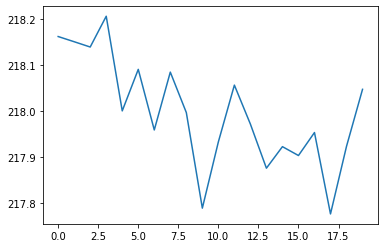

In [10]:
plt.plot(losses['test_loss'])

In [11]:
generation_testing(frozen_wiki_vae, train_dataset.unique_word_list)

Context: 
engeline		 closest match: lin
zenobert		 closest match: ober
angeline		 closest match: angeline
meline		 closest match: meline
nea		 closest match: linnea
kerlaine		 closest match: elaine
anne		 closest match: anne
renat		 closest match: renato
stephanie		 closest match: stephanie
loelline		 closest match: lin
leonie		 closest match: leonie
nathana		 closest match: nathan
neliane		 closest match: eliane
gwenna		 closest match: gwennan
nelia		 closest match: noelia
zenodoria		 closest match: zenodora
zenodore		 closest match: zenodore
noella		 closest match: noella
yannick		 closest match: yannick

Context: a
andrien		 closest match: adrien
antonine		 closest match: antonine
alyssandre		 closest match: alyssandre
anne		 closest match: anne
angeline		 closest match: angeline
aydon		 closest match: adon
andrine		 closest match: sandrine
anika		 closest match: anika
audred		 closest match: ed
annaik		 closest match: annaik
aubert		 closest match: aubert

Context: m
mariane		 clos

## Plain vae, no transfer

In [12]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)


config = GPTConfig(train_dataset.vocab_size, maxlen, n_layer=2, n_head=4, n_embd=64)
vae = AttentionVae(config)

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
number of parameters: 851904


In [16]:
vae.stoi = train_dataset.stoi
vae.itos = train_dataset.itos

In [17]:
vae.save("plain")

In [18]:
vae = AttentionVae.load("plain")

In [20]:
vae.itos

{0: '0',
 1: ' ',
 2: "'",
 3: '-',
 4: '.',
 5: 'a',
 6: 'b',
 7: 'c',
 8: 'd',
 9: 'e',
 10: 'f',
 11: 'g',
 12: 'h',
 13: 'i',
 14: 'j',
 15: 'k',
 16: 'l',
 17: 'm',
 18: 'n',
 19: 'o',
 20: 'p',
 21: 'q',
 22: 'r',
 23: 's',
 24: 't',
 25: 'u',
 26: 'v',
 27: 'w',
 28: 'x',
 29: 'y',
 30: 'z',
 31: 'à',
 32: 'â',
 33: 'ã',
 34: 'ç',
 35: 'è',
 36: 'é',
 37: 'ê',
 38: 'ë',
 39: 'î',
 40: 'ï',
 41: 'ñ',
 42: 'ô',
 43: 'ö',
 44: 'ù',
 45: 'û',
 46: 'ü'}

In [38]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)


config = GPTConfig(train_dataset.vocab_size, maxlen, n_layer=2, n_head=4, n_embd=64)
vae = AttentionVae(config)


idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), train_dataset.itos))
print("y: ",decode_word(y.numpy(), train_dataset.itos))
print("word :", decode_word(word.numpy(), train_dataset.itos))

frozen_list = []
for par in vae.named_parameters():
    if "encoder" in par[0]:
        frozen_list.append(par[0])
        
chars = list(train_dataset.stoi.keys())
maxlen = train_dataset.block_size

tconf = TrainerConfig(
    max_epochs=50,
    batch_size=256,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000,
    freeze_layers=tuple(frozen_list)
)
trainer = Trainer(vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
number of parameters: 851904
x:  genest
y:  genest
word : genest


  0%|          | 0/135 [00:00<?, ?it/s]/home/simon/code/namegen/avae/src/avae/trainer.py:123: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  self.model.parameters(), self.config.grad_norm_clip
epoch 1) iter 0: train_loss 578.5684814, lr = 5.999922e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: èèaî'                     	 closes match: valerien 
Sample: o                         	 closes match: louis 
Sample: îp                        	 closes match: paule 
Sample: ùùvè                      	 closes match: valerien 


epoch 1) iter 2: train_loss 551.1738281, lr = 5.998594e-04:   2%|▏         | 3/135 [00:02<02:56,  1.34s/it]

Sample: ièiîwã                    	 closes match: ivi 


epoch 1) iter 134: train_loss 488.6313782, lr = 3.006754e-04: 100%|██████████| 135/135 [00:12<00:00, 10.95it/s]


Test loss: 487.21453450520835


epoch 2) iter 0: train_loss 488.3554688, lr = 2.971632e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:


Sample: aanira                    	 closes match: ira 
Sample:                           	 closes match: valerien 
Sample:                           	 closes match: valerien 
Sample:                           	 closes match: valerien 


epoch 2) iter 2: train_loss 486.7881470, lr = 2.901402e-04:   2%|▏         | 3/135 [00:01<01:36,  1.36it/s]

Sample: e                         	 closes match: valerien 


epoch 2) iter 134: train_loss 488.4967041, lr = 6.000000e-05: 100%|██████████| 135/135 [00:11<00:00, 11.72it/s]


Test loss: 485.7989908854167


epoch 3) iter 0: train_loss 486.4733276, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: anian                     	 closes match: ian 
Sample: lottha                    	 closes match: lo 
Sample: le                        	 closes match: valerien 
Sample: line                      	 closes match: line 


epoch 3) iter 2: train_loss 486.0195923, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:49,  1.74s/it]

Sample: is                        	 closes match: louis 


epoch 3) iter 134: train_loss 483.8566589, lr = 3.006754e-04: 100%|██████████| 135/135 [00:12<00:00, 10.47it/s]


Test loss: 485.5696573893229


epoch 4) iter 0: train_loss 485.3874817, lr = 3.041876e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sreela                    	 closes match: elda 
Sample: lyeriea                   	 closes match: leria 
Sample: ris                       	 closes match: boris 
Sample: dimlil                    	 closes match: lily 


epoch 4) iter 2: train_loss 485.7189941, lr = 3.112098e-04:   2%|▏         | 3/135 [00:02<03:28,  1.58s/it]

Sample: menise                    	 closes match: denise 


epoch 4) iter 134: train_loss 487.0951538, lr = 5.999970e-04: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]


Test loss: 484.7049275716146


epoch 5) iter 0: train_loss 484.5809631, lr = 5.999606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: alinne                    	 closes match: aline 
Sample: conlore                   	 closes match: lo 
Sample: enne                      	 closes match: fabienne 
Sample: abane                     	 closes match: aubane 


epoch 5) iter 2: train_loss 484.6230774, lr = 5.997645e-04:   2%|▏         | 3/135 [00:02<03:37,  1.65s/it]

Sample: amale                     	 closes match: amable 


epoch 5) iter 134: train_loss 486.2016907, lr = 2.979737e-04: 100%|██████████| 135/135 [00:12<00:00, 10.61it/s]


Test loss: 484.14075724283856


epoch 6) iter 0: train_loss 485.4869385, lr = 2.944616e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: asten                     	 closes match: sten 
Sample: aricon                    	 closes match: marion 
Sample: ard                       	 closes match: godard 
Sample: pelrele                   	 closes match: perle 


epoch 6) iter 2: train_loss 484.6265869, lr = 2.874403e-04:   2%|▏         | 3/135 [00:02<03:34,  1.62s/it]

Sample: estare                    	 closes match: cesare 


epoch 6) iter 134: train_loss 487.5897827, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.64it/s]


Test loss: 484.4734619140625


epoch 7) iter 0: train_loss 485.2775269, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: eurlle                    	 closes match: erle 
Sample: am                        	 closes match: james 
Sample: oril                      	 closes match: victorilla 
Sample: cortelial                 	 closes match: lia 


epoch 7) iter 2: train_loss 485.3739624, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<04:00,  1.82s/it]

Sample: anatte                    	 closes match: ana 


epoch 7) iter 134: train_loss 485.5808411, lr = 3.033772e-04: 100%|██████████| 135/135 [00:12<00:00, 10.41it/s]


Test loss: 484.5649434407552


epoch 8) iter 0: train_loss 484.9014282, lr = 3.068890e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: astia                     	 closes match: sebastia 
Sample: leiande                   	 closes match: ian 
Sample: carnel                    	 closes match: carmel 
Sample: coron                     	 closes match: corona 


epoch 8) iter 2: train_loss 483.8270264, lr = 3.139092e-04:   2%|▏         | 3/135 [00:02<03:45,  1.70s/it]

Sample: banetttie                 	 closes match: tite 


epoch 8) iter 134: train_loss 483.3597107, lr = 5.999726e-04: 100%|██████████| 135/135 [00:12<00:00, 10.55it/s]


Test loss: 484.2408833821615


epoch 9) iter 0: train_loss 484.4329224, lr = 5.999046e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leudr                     	 closes match: fleur 
Sample: gyna                      	 closes match: gina 
Sample: sivellio                  	 closes match: stellio 
Sample: soulin                    	 closes match: lin 


epoch 9) iter 2: train_loss 484.2173462, lr = 5.996453e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: liste                     	 closes match: lis 


epoch 9) iter 134: train_loss 483.7946472, lr = 2.952721e-04: 100%|██████████| 135/135 [00:12<00:00, 10.57it/s]


Test loss: 484.0136291503906


epoch 10) iter 0: train_loss 485.2465210, lr = 2.917606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sarima                    	 closes match: sara 
Sample: martia                    	 closes match: martial 
Sample: anevan                    	 closes match: evan 
Sample: gierlo                    	 closes match: lo 


epoch 10) iter 2: train_loss 485.3145142, lr = 2.847415e-04:   2%|▏         | 3/135 [00:02<03:27,  1.57s/it]

Sample: maint                     	 closes match: mai 


epoch 10) iter 134: train_loss 483.9128113, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.70it/s]


Test loss: 483.9205586751302


epoch 11) iter 0: train_loss 485.3214111, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: esan                      	 closes match: teresa 
Sample: emin                      	 closes match: guillemine 
Sample: ranele                    	 closes match: angele 
Sample: sulllinieie               	 closes match: lin 


epoch 11) iter 2: train_loss 484.1370850, lr = 6.000000e-05:   2%|▏         | 3/135 [00:03<04:27,  2.03s/it]

Sample: andelin                   	 closes match: landelin 


epoch 11) iter 134: train_loss 483.0829468, lr = 3.060786e-04: 100%|██████████| 135/135 [00:13<00:00, 10.18it/s]


Test loss: 483.9306986490885


epoch 12) iter 0: train_loss 483.8895874, lr = 3.095897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: jantr                     	 closes match: jan 
Sample: emoinene                  	 closes match: enea 
Sample: matoriorane               	 closes match: oranne 
Sample: sterias                   	 closes match: sergia 


epoch 12) iter 2: train_loss 484.1164551, lr = 3.166075e-04:   2%|▏         | 3/135 [00:02<03:58,  1.81s/it]

Sample: elorine                   	 closes match: lorine 


epoch 12) iter 134: train_loss 484.8846130, lr = 5.999240e-04: 100%|██████████| 135/135 [00:12<00:00, 10.42it/s]


Test loss: 483.92156372070315


epoch 13) iter 0: train_loss 484.5614624, lr = 5.998243e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maernen                   	 closes match: mae 
Sample: rophrginie                	 closes match: nine 
Sample: avianinn                  	 closes match: ian 
Sample: melien                    	 closes match: melie 


epoch 13) iter 2: train_loss 485.1926270, lr = 5.995018e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: hildde                    	 closes match: hild 


epoch 13) iter 134: train_loss 483.4936523, lr = 2.925708e-04: 100%|██████████| 135/135 [00:12<00:00, 10.55it/s]


Test loss: 484.12380167643227


epoch 14) iter 0: train_loss 485.8077698, lr = 2.890602e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mary                      	 closes match: maryanick 
Sample: mahrine                   	 closes match: mahine 
Sample: maile                     	 closes match: mai 
Sample: color                     	 closes match: lo 


epoch 14) iter 2: train_loss 485.5628662, lr = 2.820438e-04:   2%|▏         | 3/135 [00:02<03:31,  1.60s/it]

Sample: leombin                   	 closes match: leo 


epoch 14) iter 134: train_loss 484.0361023, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.66it/s]


Test loss: 483.9265502929687


epoch 15) iter 0: train_loss 484.0120239, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gamyete                   	 closes match: amy 
Sample: gervar                    	 closes match: gerard 
Sample: miotune                   	 closes match: moune 
Sample: miras                     	 closes match: ira 


epoch 15) iter 2: train_loss 485.1891174, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:17,  1.50s/it]

Sample: lolene                    	 closes match: lo 


epoch 15) iter 134: train_loss 484.3526306, lr = 3.087796e-04: 100%|██████████| 135/135 [00:12<00:00, 10.77it/s]


Test loss: 484.04974161783855


epoch 16) iter 0: train_loss 484.0245972, lr = 3.122897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: enilou                    	 closes match: lo 
Sample: julannie                  	 closes match: ann 
Sample: geril                     	 closes match: meril 
Sample: dramindo                  	 closes match: ramon 


epoch 16) iter 2: train_loss 484.0877075, lr = 3.193045e-04:   2%|▏         | 3/135 [00:02<03:27,  1.58s/it]

Sample: nesmure                   	 closes match: esme 


epoch 16) iter 134: train_loss 484.7503357, lr = 5.998510e-04: 100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


Test loss: 483.8040364583333


epoch 17) iter 0: train_loss 485.2471008, lr = 5.997197e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ana                       	 closes match: ana 
Sample: narya                     	 closes match: inaya 
Sample: eurguittir                	 closes match: gui 
Sample: gulieline                 	 closes match: lin 


epoch 17) iter 2: train_loss 484.0426331, lr = 5.993340e-04:   2%|▏         | 3/135 [00:02<04:12,  1.91s/it]

Sample: assy                      	 closes match: cassylia 


epoch 17) iter 134: train_loss 485.1148987, lr = 2.898702e-04: 100%|██████████| 135/135 [00:13<00:00, 10.32it/s]


Test loss: 483.88161010742186


epoch 18) iter 0: train_loss 484.4336853, lr = 2.863607e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: elvarien                  	 closes match: iwen 
Sample: adrina                    	 closes match: adriana 
Sample: arican                    	 closes match: marian 
Sample: brianndale                	 closes match: ian 


epoch 18) iter 2: train_loss 484.6275635, lr = 2.793476e-04:   2%|▏         | 3/135 [00:02<03:53,  1.77s/it]

Sample: marisa                    	 closes match: marisa 


epoch 18) iter 134: train_loss 483.4639893, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.45it/s]


Test loss: 483.8873616536458


epoch 19) iter 0: train_loss 484.4905396, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: euminn                    	 closes match: inna 
Sample: poris                     	 closes match: boris 
Sample: thiane                    	 closes match: ian 
Sample: abatrine                  	 closes match: sabrine 


epoch 19) iter 2: train_loss 484.3332520, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:47,  1.72s/it]

Sample: mettilille                	 closes match: lee 


epoch 19) iter 134: train_loss 483.5685425, lr = 3.114798e-04: 100%|██████████| 135/135 [00:12<00:00, 10.52it/s]


Test loss: 483.7249450683594


epoch 20) iter 0: train_loss 484.8720093, lr = 3.149887e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ange                      	 closes match: ange 
Sample: amen                      	 closes match: kamen 
Sample: edollie                   	 closes match: ed 
Sample: ersan                     	 closes match: ursan 


epoch 20) iter 2: train_loss 483.6065674, lr = 3.219998e-04:   2%|▏         | 3/135 [00:02<04:00,  1.82s/it]

Sample: golie                     	 closes match: olive 


epoch 20) iter 134: train_loss 482.9155273, lr = 5.997537e-04: 100%|██████████| 135/135 [00:12<00:00, 10.40it/s]


Test loss: 483.6344909667969


epoch 21) iter 0: train_loss 483.7171631, lr = 5.995908e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aralle                    	 closes match: armaelle 
Sample: erunerna                  	 closes match: erna 
Sample: morelle                   	 closes match: melle 
Sample: bildetr                   	 closes match: benilde 


epoch 21) iter 2: train_loss 483.3556213, lr = 5.991420e-04:   2%|▏         | 3/135 [00:02<03:26,  1.56s/it]

Sample: ponnetre                  	 closes match: neree 


epoch 21) iter 134: train_loss 485.4526367, lr = 2.871704e-04: 100%|██████████| 135/135 [00:12<00:00, 10.69it/s]


Test loss: 483.69761759440104


epoch 22) iter 0: train_loss 485.3127441, lr = 2.836622e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: indiane                   	 closes match: ian 
Sample: gabiore                   	 closes match: gabie 
Sample: lysia                     	 closes match: lys 
Sample: joel                      	 closes match: joel 


epoch 22) iter 2: train_loss 484.2916870, lr = 2.766531e-04:   2%|▏         | 3/135 [00:02<03:23,  1.54s/it]

Sample: gaudare                   	 closes match: ares 


epoch 22) iter 134: train_loss 482.2058411, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.74it/s]


Test loss: 483.5635131835937


epoch 23) iter 0: train_loss 483.8209229, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: than                      	 closes match: athanasie 
Sample: marystie                  	 closes match: maryse 
Sample: mil                       	 closes match: camille 
Sample: anickele                  	 closes match: nick 


epoch 23) iter 2: train_loss 483.4027100, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:52,  1.76s/it]

Sample: jinyll                    	 closes match: jill 


epoch 23) iter 134: train_loss 483.1990662, lr = 3.141791e-04: 100%|██████████| 135/135 [00:12<00:00, 10.47it/s]


Test loss: 483.6202819824219


epoch 24) iter 0: train_loss 483.8082581, lr = 3.176865e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: eturina                   	 closes match: venturin 
Sample: eulian                    	 closes match: elian 
Sample: maria                     	 closes match: maria 
Sample: alious                    	 closes match: ali 


epoch 24) iter 2: train_loss 485.2733459, lr = 3.246934e-04:   2%|▏         | 3/135 [00:02<03:26,  1.56s/it]

Sample: bence                     	 closes match: ben 


epoch 24) iter 134: train_loss 483.8973389, lr = 5.996320e-04: 100%|██████████| 135/135 [00:12<00:00, 10.71it/s]


Test loss: 483.60015665690105


epoch 25) iter 0: train_loss 483.8979187, lr = 5.994376e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: matthe                    	 closes match: mattheo 
Sample: amanuie                   	 closes match: amandine 
Sample: anton                     	 closes match: anton 
Sample: slauu                     	 closes match: salaun 


epoch 25) iter 2: train_loss 484.1356506, lr = 5.989256e-04:   2%|▏         | 3/135 [00:02<03:16,  1.49s/it]

Sample: aloda                     	 closes match: oda 


epoch 25) iter 134: train_loss 484.7500000, lr = 2.844716e-04: 100%|██████████| 135/135 [00:12<00:00, 10.79it/s]


Test loss: 483.7190734863281


epoch 26) iter 0: train_loss 483.2943726, lr = 2.809652e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: edie                      	 closes match: ed 
Sample: ermainn                   	 closes match: mai 
Sample: bicthye                   	 closes match: thea 
Sample: mianale                   	 closes match: ian 


epoch 26) iter 2: train_loss 484.0976562, lr = 2.739605e-04:   2%|▏         | 3/135 [00:02<03:44,  1.70s/it]

Sample: sidbonani                 	 closes match: bona 


epoch 26) iter 134: train_loss 484.3153687, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.52it/s]


Test loss: 483.6540486653646


epoch 27) iter 0: train_loss 484.1243896, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: anonotar                  	 closes match: ano 
Sample: ellemia                   	 closes match: mia 
Sample: anchela                   	 closes match: ancel 
Sample: bylberte                  	 closes match: bert 


epoch 27) iter 2: train_loss 483.9616089, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:22,  1.54s/it]

Sample: jemardra                  	 closes match: dora 


epoch 27) iter 134: train_loss 484.7559204, lr = 3.168773e-04: 100%|██████████| 135/135 [00:12<00:00, 10.73it/s]


Test loss: 483.63816731770834


epoch 28) iter 0: train_loss 484.9788818, lr = 3.203828e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: cosstim                   	 closes match: tim 
Sample: cornat                    	 closes match: orna 
Sample: eventola                  	 closes match: even 
Sample: emalie                    	 closes match: ali 


epoch 28) iter 2: train_loss 483.5157471, lr = 3.273850e-04:   2%|▏         | 3/135 [00:02<03:24,  1.55s/it]

Sample: landro                    	 closes match: leandro 


epoch 28) iter 134: train_loss 482.3625183, lr = 5.994861e-04: 100%|██████████| 135/135 [00:12<00:00, 10.71it/s]


Test loss: 483.68079427083336


epoch 29) iter 0: train_loss 484.0036011, lr = 5.992601e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: andonic                   	 closes match: andronic 
Sample: eve                       	 closes match: everilde 
Sample: edana                     	 closes match: ed 
Sample: pasthya                   	 closes match: thea 


epoch 29) iter 2: train_loss 482.8516541, lr = 5.986851e-04:   2%|▏         | 3/135 [00:02<03:21,  1.53s/it]

Sample: ailys                     	 closes match: lys 


epoch 29) iter 134: train_loss 483.6976624, lr = 2.817741e-04: 100%|██████████| 135/135 [00:12<00:00, 10.72it/s]


Test loss: 483.8476196289063


epoch 30) iter 0: train_loss 484.0449219, lr = 2.782696e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: timia                     	 closes match: mia 
Sample: nard                      	 closes match: lienard 
Sample: claido                    	 closes match: clio 
Sample: serin                     	 closes match: sernin 


epoch 30) iter 2: train_loss 483.2302856, lr = 2.712700e-04:   2%|▏         | 3/135 [00:02<03:35,  1.63s/it]

Sample: galdime                   	 closes match: imre 


epoch 30) iter 134: train_loss 482.2523804, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.62it/s]


Test loss: 483.5197428385417


epoch 31) iter 0: train_loss 484.3165894, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: meon                      	 closes match: symeon 
Sample: loria                     	 closes match: lorian 
Sample: beral                     	 closes match: liberal 
Sample: alorian                   	 closes match: lorian 


epoch 31) iter 2: train_loss 484.1690674, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:45,  1.71s/it]

Sample: ciena                     	 closes match: siena 


epoch 31) iter 134: train_loss 485.2462769, lr = 3.195741e-04: 100%|██████████| 135/135 [00:12<00:00, 10.51it/s]


Test loss: 483.7136922200521


epoch 32) iter 0: train_loss 483.0034180, lr = 3.230775e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: bittoucaline              	 closes match: caline 
Sample: rombaurino                	 closes match: maurin 
Sample: alomicane                 	 closes match: lo 
Sample: albalia                   	 closes match: lia 


epoch 32) iter 2: train_loss 484.0567017, lr = 3.300744e-04:   2%|▏         | 3/135 [00:03<04:58,  2.26s/it]

Sample: francian                  	 closes match: franciane 


epoch 32) iter 134: train_loss 482.8062134, lr = 5.993159e-04: 100%|██████████| 135/135 [00:13<00:00,  9.73it/s]


Test loss: 483.41253662109375


epoch 33) iter 0: train_loss 483.9537964, lr = 5.990583e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aeliane                   	 closes match: ameliane 
Sample: dovita                    	 closes match: ita 
Sample: lal                       	 closes match: eulalie 
Sample: ana                       	 closes match: ana 


epoch 33) iter 2: train_loss 483.3786621, lr = 5.984203e-04:   2%|▏         | 3/135 [00:02<03:51,  1.75s/it]

Sample: gadiline                  	 closes match: lin 


epoch 33) iter 134: train_loss 484.5314331, lr = 2.790781e-04: 100%|██████████| 135/135 [00:12<00:00, 10.42it/s]


Test loss: 483.39015706380206


epoch 34) iter 0: train_loss 483.3970032, lr = 2.755758e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: marilia                   	 closes match: lia 
Sample: lembe                     	 closes match: lee 
Sample: peandit                   	 closes match: ita 
Sample: armen                     	 closes match: carmen 


epoch 34) iter 2: train_loss 484.2499084, lr = 2.685818e-04:   2%|▏         | 3/135 [00:02<03:19,  1.51s/it]

Sample: fariane                   	 closes match: ariane 


epoch 34) iter 134: train_loss 484.2650452, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.56it/s]


Test loss: 483.570556640625


epoch 35) iter 0: train_loss 484.3400574, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: salin                     	 closes match: messaline 
Sample: carlatia                  	 closes match: tia 
Sample: nimia                     	 closes match: mia 
Sample: rodgirda                  	 closes match: ogier 


epoch 35) iter 2: train_loss 484.1432495, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:42,  1.68s/it]

Sample: albie                     	 closes match: albine 


epoch 35) iter 134: train_loss 483.7534180, lr = 3.222693e-04: 100%|██████████| 135/135 [00:13<00:00, 10.36it/s]


Test loss: 483.52158610026044


epoch 36) iter 0: train_loss 483.5609741, lr = 3.257703e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: anoula                    	 closes match: ano 
Sample: milge                     	 closes match: emile 
Sample: selvarit                  	 closes match: rite 
Sample: perr                      	 closes match: perrine 


epoch 36) iter 2: train_loss 483.9077759, lr = 3.327613e-04:   2%|▏         | 3/135 [00:02<03:38,  1.66s/it]

Sample: alianne                   	 closes match: alanne 


epoch 36) iter 134: train_loss 483.1935425, lr = 5.991214e-04: 100%|██████████| 135/135 [00:13<00:00, 10.31it/s]


Test loss: 483.56622924804685


epoch 37) iter 0: train_loss 483.2249756, lr = 5.988323e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sirva                     	 closes match: sirpa 
Sample: eudiovered                	 closes match: ed 
Sample: manoria                   	 closes match: oria 
Sample: lucych                    	 closes match: lucy 


epoch 37) iter 2: train_loss 483.8845215, lr = 5.981313e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: bridanet                  	 closes match: aneth 


epoch 37) iter 134: train_loss 483.1107788, lr = 2.763838e-04: 100%|██████████| 135/135 [00:13<00:00, 10.00it/s]


Test loss: 483.3795674641927


epoch 38) iter 0: train_loss 482.6054382, lr = 2.728841e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mirian                    	 closes match: miria 
Sample: fald                      	 closes match: mafalda 
Sample: maryce                    	 closes match: marcie 
Sample: jodesan                   	 closes match: des 


epoch 38) iter 2: train_loss 482.7784424, lr = 2.658962e-04:   2%|▏         | 3/135 [00:02<03:30,  1.60s/it]

Sample: ervitt                    	 closes match: itta 


epoch 38) iter 134: train_loss 483.1724854, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.36it/s]


Test loss: 483.3843139648437


epoch 39) iter 0: train_loss 483.5372925, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maelione                  	 closes match: maeline 
Sample: landore                   	 closes match: leandre 
Sample: mail                      	 closes match: mailis 
Sample: nardiane                  	 closes match: ian 


epoch 39) iter 2: train_loss 483.4683838, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:57,  1.80s/it]

Sample: laisylla                  	 closes match: ladislas 


epoch 39) iter 134: train_loss 483.5034485, lr = 3.249627e-04: 100%|██████████| 135/135 [00:13<00:00, 10.03it/s]


Test loss: 483.36118977864584


epoch 40) iter 0: train_loss 482.8311768, lr = 3.284610e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: marianalin                	 closes match: ian 
Sample: mary                      	 closes match: maryanick 
Sample: josain                    	 closes match: jos 
Sample: maell                     	 closes match: maelle 


epoch 40) iter 2: train_loss 483.5126648, lr = 3.354456e-04:   2%|▏         | 3/135 [00:02<03:57,  1.80s/it]

Sample: moteran                   	 closes match: moderan 


epoch 40) iter 134: train_loss 484.6538696, lr = 5.989027e-04: 100%|██████████| 135/135 [00:13<00:00, 10.19it/s]


Test loss: 483.32823893229164


epoch 41) iter 0: train_loss 484.5949402, lr = 5.985821e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aliena                    	 closes match: alena 
Sample: gabillaine                	 closes match: bill 
Sample: arsea                     	 closes match: aurea 
Sample: abyert                    	 closes match: aubert 


epoch 41) iter 2: train_loss 483.0265808, lr = 5.978181e-04:   2%|▏         | 3/135 [00:02<03:54,  1.77s/it]

Sample: malchie                   	 closes match: malachie 


epoch 41) iter 134: train_loss 484.9646912, lr = 2.736914e-04: 100%|██████████| 135/135 [00:13<00:00, 10.16it/s]


Test loss: 483.5283467610677


epoch 42) iter 0: train_loss 483.5822754, lr = 2.701945e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: eles                      	 closes match: celestin 
Sample: maya                      	 closes match: maya 
Sample: goelieme                  	 closes match: elie 
Sample: munev                     	 closes match: moune 


epoch 42) iter 2: train_loss 483.8184204, lr = 2.632134e-04:   2%|▏         | 3/135 [00:02<04:07,  1.88s/it]

Sample: mogieryco                 	 closes match: ogier 


epoch 42) iter 134: train_loss 482.7279358, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.94it/s]


Test loss: 483.2110595703125


epoch 43) iter 0: train_loss 483.5483398, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: arssine                   	 closes match: yassine 
Sample: claucina                  	 closes match: lucinda 
Sample: laalia                    	 closes match: lia 
Sample: samphane                  	 closes match: sam 


epoch 43) iter 2: train_loss 483.3494263, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:48,  1.73s/it]

Sample: aude                      	 closes match: aude 


epoch 43) iter 134: train_loss 483.5430908, lr = 3.276541e-04: 100%|██████████| 135/135 [00:13<00:00, 10.21it/s]


Test loss: 483.23060913085936


epoch 44) iter 0: train_loss 482.8204041, lr = 3.311494e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: abelide                   	 closes match: abel 
Sample: therad                    	 closes match: thea 
Sample: nathes                    	 closes match: natheo 
Sample: stalessine                	 closes match: ines 


epoch 44) iter 2: train_loss 484.1735840, lr = 3.381270e-04:   2%|▏         | 3/135 [00:02<03:42,  1.69s/it]

Sample: nanckan                   	 closes match: kaan 


epoch 44) iter 134: train_loss 483.9988708, lr = 5.986597e-04: 100%|██████████| 135/135 [00:13<00:00, 10.28it/s]


Test loss: 483.273036702474


epoch 45) iter 0: train_loss 483.6570435, lr = 5.983076e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: fancam                    	 closes match: franca 
Sample: marco                     	 closes match: marco 
Sample: geraice                   	 closes match: grace 
Sample: bodulmin                  	 closes match: mina 


epoch 45) iter 2: train_loss 483.2796021, lr = 5.974808e-04:   2%|▏         | 3/135 [00:02<03:28,  1.58s/it]

Sample: marel                     	 closes match: marcel 


epoch 45) iter 134: train_loss 482.0370483, lr = 2.710011e-04: 100%|██████████| 135/135 [00:13<00:00, 10.37it/s]


Test loss: 483.36560872395836


epoch 46) iter 0: train_loss 483.1158142, lr = 2.675073e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: franceline                	 closes match: franceline 
Sample: alis                      	 closes match: alis 
Sample: elina                     	 closes match: elina 
Sample: janalau                   	 closes match: jan 


epoch 46) iter 2: train_loss 484.0916748, lr = 2.605335e-04:   2%|▏         | 3/135 [00:02<03:58,  1.80s/it]

Sample: fidiera                   	 closes match: erna 


epoch 46) iter 134: train_loss 482.9876099, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.16it/s]


Test loss: 483.32959798177086


epoch 47) iter 0: train_loss 483.8038940, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: coralena                  	 closes match: alena 
Sample: marlecie                  	 closes match: marcie 
Sample: mais                      	 closes match: maissane 
Sample: elitha                    	 closes match: elita 


epoch 47) iter 2: train_loss 483.0979309, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:59,  1.81s/it]

Sample: joanne                    	 closes match: johanne 


epoch 47) iter 134: train_loss 483.4161072, lr = 3.303432e-04: 100%|██████████| 135/135 [00:13<00:00,  9.96it/s]


Test loss: 483.2621175130208


epoch 48) iter 0: train_loss 484.2221680, lr = 3.338353e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: soce                      	 closes match: solene 
Sample: greguile                  	 closes match: greg 
Sample: france                    	 closes match: france 
Sample: elian                     	 closes match: elian 


epoch 48) iter 2: train_loss 483.3438721, lr = 3.408053e-04:   2%|▏         | 3/135 [00:02<04:03,  1.84s/it]

Sample: elia                      	 closes match: elia 


epoch 48) iter 134: train_loss 485.1409607, lr = 5.983925e-04: 100%|██████████| 135/135 [00:13<00:00,  9.94it/s]


Test loss: 483.167079671224


epoch 49) iter 0: train_loss 483.6304016, lr = 5.980089e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aidea                     	 closes match: aida 
Sample: mathorine                 	 closes match: mathurine 
Sample: claris                    	 closes match: clar 
Sample: goulttia                  	 closes match: tia 


epoch 49) iter 2: train_loss 483.1443787, lr = 5.971193e-04:   2%|▏         | 3/135 [00:02<04:09,  1.89s/it]

Sample: saby                      	 closes match: saby 


epoch 49) iter 134: train_loss 484.0125427, lr = 2.683132e-04: 100%|██████████| 135/135 [00:13<00:00,  9.94it/s]


Test loss: 483.2302693684896


epoch 50) iter 0: train_loss 484.0217896, lr = 2.648227e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: simie                     	 closes match: aimie 
Sample: guene                     	 closes match: guenael 
Sample: finedy                    	 closes match: fine 
Sample: lucrice                   	 closes match: luc 


epoch 50) iter 2: train_loss 483.6258850, lr = 2.578568e-04:   2%|▏         | 3/135 [00:02<03:31,  1.60s/it]

Sample: brunnael                  	 closes match: ael 


epoch 50) iter 134: train_loss 484.5942688, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.17it/s]


Test loss: 483.12848307291665


In [13]:
vae.save("plain")

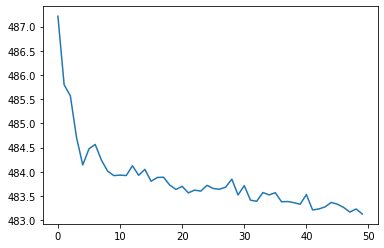

In [39]:
plt.plot(losses['test_loss'])

In [40]:
generation_testing(vae, train_dataset.unique_word_list)

Context: 
andrie		 closest match: andrieu
mariane		 closest match: marciane
alexandrine		 closest match: alexandrine
alexandrin		 closest match: alexandrin
amaria		 closest match: maria
annaelle		 closest match: annaelle
anna		 closest match: anna
albert		 closest match: albert
andria		 closest match: andreia
anseline		 closest match: anselin
marian		 closest match: marian
anaelle		 closest match: anaelle
maria		 closest match: maria
andric		 closest match: andronic
alissa		 closest match: aissa
anton		 closest match: anton
andrein		 closest match: andreia

Context: a
andrie		 closest match: andrieu
alexandric		 closest match: alex
angeline		 closest match: angeline
annaelle		 closest match: annaelle
andria		 closest match: andreia
albert		 closest match: albert
andrine		 closest match: sandrine
alexand		 closest match: alex
alexandre		 closest match: alex
alexan		 closest match: alexane
anaelle		 closest match: anaelle
andric		 closest match: andronic
alexine		 closest match: alexine


## French model, freeze 

In [41]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
frozen_french_vae = AttentionVae.load("french_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), frozen_french_vae.itos))
print("y: ",decode_word(y.numpy(), frozen_french_vae.itos))
print("word :", decode_word(word.numpy(), frozen_french_vae.itos))

frozen_list = []
for par in frozen_french_vae.named_parameters():
    if "encoder" in par[0]:
        frozen_list.append(par[0])

chars = list(frozen_french_vae.stoi.keys())
maxlen = frozen_french_vae.config.block_size

tconf = TrainerConfig(
    max_epochs=40,
    batch_size=256,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000,
    freeze_layers=tuple(frozen_list)
)
trainer = Trainer(frozen_french_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


epoch 1) iter 0: train_loss 224.2957458, lr = 5.999922e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: igle                      	 closes match: theophile 
Sample: alée                      	 closes match: valerien 
Sample: dérie                     	 closes match: adrienne 
Sample: clai                      	 closes match: clairette 


epoch 1) iter 2: train_loss 224.1293030, lr = 5.998594e-04:   2%|▏         | 3/135 [00:03<04:49,  2.19s/it]

Sample: perterient                	 closes match: per 


epoch 1) iter 134: train_loss 221.4048767, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00,  9.81it/s]


Test loss: 222.1877451578776


epoch 2) iter 0: train_loss 222.0484009, lr = 2.971632e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sebort                    	 closes match: sigebert 
Sample: lystia                    	 closes match: lys 
Sample: calle                     	 closes match: callie 
Sample: mina                      	 closes match: mina 


epoch 2) iter 2: train_loss 222.4422913, lr = 2.901402e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: glaule                    	 closes match: paule 


epoch 2) iter 134: train_loss 222.8915558, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.32it/s]


Test loss: 222.0229064941406


epoch 3) iter 0: train_loss 222.3374634, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lory                      	 closes match: lo 
Sample: louenne                   	 closes match: lo 
Sample: corinte                   	 closes match: corine 
Sample: melan                     	 closes match: melane 


epoch 3) iter 2: train_loss 222.8615875, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:28,  1.58s/it]

Sample: barilie                   	 closes match: bertilie 


epoch 3) iter 134: train_loss 222.8808136, lr = 3.006754e-04: 100%|██████████| 135/135 [00:12<00:00, 10.44it/s]


Test loss: 222.02972615559895


epoch 4) iter 0: train_loss 222.2699585, lr = 3.041876e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lauless                   	 closes match: alessio 
Sample: joaspe                    	 closes match: joas 
Sample: mastala                   	 closes match: alar 
Sample: anielbect                 	 closes match: electa 


epoch 4) iter 2: train_loss 221.8226318, lr = 3.112098e-04:   2%|▏         | 3/135 [00:02<03:36,  1.64s/it]

Sample: guele                     	 closes match: guenole 


epoch 4) iter 134: train_loss 221.9241028, lr = 5.999970e-04: 100%|██████████| 135/135 [00:12<00:00, 10.39it/s]


Test loss: 222.01986796061198


epoch 5) iter 0: train_loss 221.6114807, lr = 5.999606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: jose                      	 closes match: jose 
Sample: garosin                   	 closes match: rosine 
Sample: jota                      	 closes match: jo 
Sample: catylone                  	 closes match: lo 


epoch 5) iter 2: train_loss 222.4671326, lr = 5.997645e-04:   2%|▏         | 3/135 [00:02<03:52,  1.76s/it]

Sample: maryn                     	 closes match: marilyn 


epoch 5) iter 134: train_loss 221.9000549, lr = 2.979737e-04: 100%|██████████| 135/135 [00:13<00:00, 10.36it/s]


Test loss: 221.89695638020834


epoch 6) iter 0: train_loss 221.9836578, lr = 2.944616e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: adoline                   	 closes match: lin 
Sample: stine                     	 closes match: satine 
Sample: grigodan                  	 closes match: oda 
Sample: hoda                      	 closes match: oda 


epoch 6) iter 2: train_loss 221.9230957, lr = 2.874403e-04:   2%|▏         | 3/135 [00:02<03:36,  1.64s/it]

Sample: maudan                    	 closes match: maud 


epoch 6) iter 134: train_loss 222.2267303, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.57it/s]


Test loss: 221.76575826009113


epoch 7) iter 0: train_loss 222.2186584, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sompho                    	 closes match: symphoriane 
Sample: adia                      	 closes match: radiane 
Sample: authaine                  	 closes match: aigne 
Sample: lonane                    	 closes match: loane 


epoch 7) iter 2: train_loss 222.1646729, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:38,  1.65s/it]

Sample: jeannie                   	 closes match: jeannie 


epoch 7) iter 134: train_loss 222.2477112, lr = 3.033772e-04: 100%|██████████| 135/135 [00:12<00:00, 10.57it/s]


Test loss: 221.89495849609375


epoch 8) iter 0: train_loss 221.1604462, lr = 3.068890e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: muresilane                	 closes match: resi 
Sample: lillordo                  	 closes match: lo 
Sample: lusine                    	 closes match: melusine 
Sample: gulariande                	 closes match: ian 


epoch 8) iter 2: train_loss 222.2052307, lr = 3.139092e-04:   2%|▏         | 3/135 [00:03<04:31,  2.06s/it]

Sample: heastelemo                	 closes match: astere 


epoch 8) iter 134: train_loss 222.4199066, lr = 5.999726e-04: 100%|██████████| 135/135 [00:13<00:00, 10.12it/s]


Test loss: 221.887006632487


epoch 9) iter 0: train_loss 222.0164337, lr = 5.999046e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: teron                     	 closes match: trond 
Sample: chiotta                   	 closes match: itta 
Sample: mena                      	 closes match: menas 
Sample: sarcy                     	 closes match: darcy 


epoch 9) iter 2: train_loss 222.0215454, lr = 5.996453e-04:   2%|▏         | 3/135 [00:02<03:38,  1.66s/it]

Sample: emwrause                  	 closes match: sue 


epoch 9) iter 134: train_loss 222.7666626, lr = 2.952721e-04: 100%|██████████| 135/135 [00:12<00:00, 10.56it/s]


Test loss: 221.78516031901043


epoch 10) iter 0: train_loss 221.1206970, lr = 2.917606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: santina                   	 closes match: tina 
Sample: lyarde                    	 closes match: lya 
Sample: sylvier                   	 closes match: sylver 
Sample: jouric                    	 closes match: jo 


epoch 10) iter 2: train_loss 221.7868652, lr = 2.847415e-04:   2%|▏         | 3/135 [00:02<03:13,  1.46s/it]

Sample: maryce                    	 closes match: marcie 


epoch 10) iter 134: train_loss 221.2742920, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.62it/s]


Test loss: 221.6713897705078


epoch 11) iter 0: train_loss 221.7218628, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maxeline                  	 closes match: maeline 
Sample: mande                     	 closes match: allamande 
Sample: and                       	 closes match: cassandre 
Sample: loana                     	 closes match: loana 


epoch 11) iter 2: train_loss 221.9143066, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:42,  1.68s/it]

Sample: elyette                   	 closes match: elyette 


epoch 11) iter 134: train_loss 219.9869690, lr = 3.060786e-04: 100%|██████████| 135/135 [00:12<00:00, 10.45it/s]


Test loss: 221.67173868815104


epoch 12) iter 0: train_loss 221.4021912, lr = 3.095897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: jerenna                   	 closes match: jenna 
Sample: merisa                    	 closes match: marisa 
Sample: sanchels                  	 closes match: sanche 
Sample: syllanans                 	 closes match: lana 


epoch 12) iter 2: train_loss 221.4173279, lr = 3.166075e-04:   2%|▏         | 3/135 [00:02<03:53,  1.77s/it]

Sample: jann                      	 closes match: jannick 


epoch 12) iter 134: train_loss 221.4891357, lr = 5.999240e-04: 100%|██████████| 135/135 [00:12<00:00, 10.43it/s]


Test loss: 221.70427856445312


epoch 13) iter 0: train_loss 221.5893555, lr = 5.998243e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: surst                     	 closes match: urs 
Sample: anariarina                	 closes match: ana 
Sample: synie                     	 closes match: euphrosyne 
Sample: jonara                    	 closes match: jo 


epoch 13) iter 2: train_loss 221.4609680, lr = 5.995018e-04:   2%|▏         | 3/135 [00:02<03:35,  1.63s/it]

Sample: ermilar                   	 closes match: mila 


epoch 13) iter 134: train_loss 222.7083130, lr = 2.925708e-04: 100%|██████████| 135/135 [00:12<00:00, 10.58it/s]


Test loss: 221.5946075439453


epoch 14) iter 0: train_loss 221.5726624, lr = 2.890602e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maill                     	 closes match: mai 
Sample: marcie                    	 closes match: marcie 
Sample: even                      	 closes match: even 
Sample: tisellacine               	 closes match: ella 


epoch 14) iter 2: train_loss 221.7339783, lr = 2.820438e-04:   2%|▏         | 3/135 [00:03<04:25,  2.01s/it]

Sample: coreline                  	 closes match: lin 


epoch 14) iter 134: train_loss 221.8868561, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.14it/s]


Test loss: 221.50588785807292


epoch 15) iter 0: train_loss 221.3694611, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: galia                     	 closes match: galia 
Sample: josellina                 	 closes match: jos 
Sample: lenalle                   	 closes match: lenaelle 
Sample: july                      	 closes match: julyann 


epoch 15) iter 2: train_loss 221.7143250, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<04:03,  1.84s/it]

Sample: alamassele                	 closes match: elne 


epoch 15) iter 134: train_loss 221.9545441, lr = 3.087796e-04: 100%|██████████| 135/135 [00:13<00:00, 10.36it/s]


Test loss: 221.60002746582032


epoch 16) iter 0: train_loss 221.9356384, lr = 3.122897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mathi                     	 closes match: mathie 
Sample: goullde                   	 closes match: des 
Sample: cantitis                  	 closes match: titus 
Sample: chrisilla                 	 closes match: christilla 


epoch 16) iter 2: train_loss 221.3696289, lr = 3.193045e-04:   2%|▏         | 3/135 [00:02<03:31,  1.60s/it]

Sample: madelle                   	 closes match: maelle 


epoch 16) iter 134: train_loss 221.6931152, lr = 5.998510e-04: 100%|██████████| 135/135 [00:12<00:00, 10.62it/s]


Test loss: 221.652387491862


epoch 17) iter 0: train_loss 221.4787903, lr = 5.997197e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: edia                      	 closes match: ed 
Sample: anaelis                   	 closes match: anae 
Sample: paulieure                 	 closes match: paul 
Sample: marcine                   	 closes match: marciane 


epoch 17) iter 2: train_loss 221.6759644, lr = 5.993340e-04:   2%|▏         | 3/135 [00:02<03:52,  1.76s/it]

Sample: edvra                     	 closes match: ed 


epoch 17) iter 134: train_loss 222.1578827, lr = 2.898702e-04: 100%|██████████| 135/135 [00:12<00:00, 10.42it/s]


Test loss: 221.57027180989584


epoch 18) iter 0: train_loss 221.5606537, lr = 2.863607e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: silia                     	 closes match: lia 
Sample: aldy                      	 closes match: waldy 
Sample: lyaecerane                	 closes match: lya 
Sample: tuiere                    	 closes match: erle 


epoch 18) iter 2: train_loss 221.2236786, lr = 2.793476e-04:   2%|▏         | 3/135 [00:02<04:02,  1.84s/it]

Sample: sylouert                  	 closes match: lo 


epoch 18) iter 134: train_loss 221.3888855, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.33it/s]


Test loss: 221.4576202392578


epoch 19) iter 0: train_loss 221.1948242, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gelinil                   	 closes match: lin 
Sample: telin                     	 closes match: lin 
Sample: leaus                     	 closes match: lea 
Sample: giandy                    	 closes match: andy 


epoch 19) iter 2: train_loss 220.9932556, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:22,  1.53s/it]

Sample: edrik                     	 closes match: ed 


epoch 19) iter 134: train_loss 221.7696228, lr = 3.114798e-04: 100%|██████████| 135/135 [00:12<00:00, 10.70it/s]


Test loss: 221.51946818033855


epoch 20) iter 0: train_loss 221.0654297, lr = 3.149887e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: santriana                 	 closes match: ian 
Sample: savanne                   	 closes match: anne 
Sample: fredy                     	 closes match: freddy 
Sample: agoea                     	 closes match: angela 


epoch 20) iter 2: train_loss 221.2215576, lr = 3.219998e-04:   2%|▏         | 3/135 [00:02<04:07,  1.88s/it]

Sample: francelie                 	 closes match: franceline 


epoch 20) iter 134: train_loss 221.5717621, lr = 5.997537e-04: 100%|██████████| 135/135 [00:13<00:00, 10.32it/s]


Test loss: 221.5572479248047


epoch 21) iter 0: train_loss 221.5462341, lr = 5.995908e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ardorino                  	 closes match: adriano 
Sample: maland                    	 closes match: alan 
Sample: etermyn                   	 closes match: emmy 
Sample: megwer                    	 closes match: leger 


epoch 21) iter 2: train_loss 221.1374512, lr = 5.991420e-04:   2%|▏         | 3/135 [00:02<03:41,  1.67s/it]

Sample: sydueline                 	 closes match: lin 


epoch 21) iter 134: train_loss 221.0284576, lr = 2.871704e-04: 100%|██████████| 135/135 [00:12<00:00, 10.53it/s]


Test loss: 221.46563924153645


epoch 22) iter 0: train_loss 220.9438477, lr = 2.836622e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: stana                     	 closes match: tristana 
Sample: comprenti                 	 closes match: corentin 
Sample: benondva                  	 closes match: ben 
Sample: gorina                    	 closes match: georgina 


epoch 22) iter 2: train_loss 220.9869080, lr = 2.766531e-04:   2%|▏         | 3/135 [00:02<03:52,  1.76s/it]

Sample: altia                     	 closes match: tia 


epoch 22) iter 134: train_loss 221.9742279, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.43it/s]


Test loss: 221.41360880533855


epoch 23) iter 0: train_loss 220.6464233, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sifien                    	 closes match: if 
Sample: goderett                  	 closes match: ode 
Sample: santie                    	 closes match: santine 
Sample: leona                     	 closes match: leona 


epoch 23) iter 2: train_loss 221.2433167, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:46,  1.71s/it]

Sample: elia                      	 closes match: elia 


epoch 23) iter 134: train_loss 220.9674225, lr = 3.141791e-04: 100%|██████████| 135/135 [00:12<00:00, 10.48it/s]


Test loss: 221.48346964518228


epoch 24) iter 0: train_loss 221.0415802, lr = 3.176865e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: marceoic                  	 closes match: marc 
Sample: foult                     	 closes match: fulton 
Sample: artine                    	 closes match: martine 
Sample: larn                      	 closes match: lauren 


epoch 24) iter 2: train_loss 220.8167572, lr = 3.246934e-04:   2%|▏         | 3/135 [00:02<03:49,  1.74s/it]

Sample: simere                    	 closes match: imre 


epoch 24) iter 134: train_loss 221.1413574, lr = 5.996320e-04: 100%|██████████| 135/135 [00:12<00:00, 10.44it/s]


Test loss: 221.47669779459636


epoch 25) iter 0: train_loss 221.0325012, lr = 5.994376e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: adricis                   	 closes match: aldric 
Sample: evelice                   	 closes match: eveline 
Sample: eran                      	 closes match: zerane 
Sample: artult                    	 closes match: arnoult 


epoch 25) iter 2: train_loss 221.8973999, lr = 5.989256e-04:   2%|▏         | 3/135 [00:02<03:35,  1.63s/it]

Sample: drinaeld                  	 closes match: ael 


epoch 25) iter 134: train_loss 220.3537292, lr = 2.844716e-04: 100%|██████████| 135/135 [00:12<00:00, 10.60it/s]


Test loss: 221.3191884358724


epoch 26) iter 0: train_loss 220.8240356, lr = 2.809652e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sana                      	 closes match: lysana 
Sample: francedo                  	 closes match: ed 
Sample: notta                     	 closes match: noa 
Sample: anaiene                   	 closes match: ana 


epoch 26) iter 2: train_loss 220.9136047, lr = 2.739605e-04:   2%|▏         | 3/135 [00:02<03:37,  1.65s/it]

Sample: madela                    	 closes match: maela 


epoch 26) iter 134: train_loss 220.5164337, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.57it/s]


Test loss: 221.41665751139323


epoch 27) iter 0: train_loss 220.7654724, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: serophe                   	 closes match: seraphie 
Sample: servane                   	 closes match: servane 
Sample: elbert                    	 closes match: madelberte 
Sample: eliakae                   	 closes match: lia 


epoch 27) iter 2: train_loss 220.8162384, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:11,  1.45s/it]

Sample: jasianiq                  	 closes match: ian 


epoch 27) iter 134: train_loss 220.1140900, lr = 3.168773e-04: 100%|██████████| 135/135 [00:12<00:00, 10.82it/s]


Test loss: 221.45013020833332


epoch 28) iter 0: train_loss 221.2815552, lr = 3.203828e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: saleg                     	 closes match: salve 
Sample: angelle                   	 closes match: angele 
Sample: ferdy                     	 closes match: fe 
Sample: selfricia                 	 closes match: elicia 


epoch 28) iter 2: train_loss 221.4391479, lr = 3.273850e-04:   2%|▏         | 3/135 [00:02<03:42,  1.68s/it]

Sample: lonia                     	 closes match: lo 


epoch 28) iter 134: train_loss 220.9391327, lr = 5.994861e-04: 100%|██████████| 135/135 [00:12<00:00, 10.54it/s]


Test loss: 221.45245564778645


epoch 29) iter 0: train_loss 221.3355255, lr = 5.992601e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: melya                     	 closes match: maelya 
Sample: jultama                   	 closes match: alma 
Sample: madouna                   	 closes match: maona 
Sample: fravie                    	 closes match: flavien 


epoch 29) iter 2: train_loss 221.0339661, lr = 5.986851e-04:   2%|▏         | 3/135 [00:02<03:28,  1.58s/it]

Sample: riv                       	 closes match: brivaelle 


epoch 29) iter 134: train_loss 222.0179901, lr = 2.817741e-04: 100%|██████████| 135/135 [00:12<00:00, 10.66it/s]


Test loss: 221.45541178385417


epoch 30) iter 0: train_loss 220.7104034, lr = 2.782696e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: litha                     	 closes match: talitha 
Sample: ladettic                  	 closes match: laeticia 
Sample: lorenne                   	 closes match: florenne 
Sample: anegue                    	 closes match: neige 


epoch 30) iter 2: train_loss 221.4290161, lr = 2.712700e-04:   2%|▏         | 3/135 [00:02<03:40,  1.67s/it]

Sample: charlette                 	 closes match: charlette 


epoch 30) iter 134: train_loss 221.4206848, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.52it/s]


Test loss: 221.3711191813151


epoch 31) iter 0: train_loss 220.8732300, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: guille                    	 closes match: guillemine 
Sample: pepron                    	 closes match: petrone 
Sample: jusie                     	 closes match: justine 
Sample: cettane                   	 closes match: anne 


epoch 31) iter 2: train_loss 220.3692322, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:20,  1.52s/it]

Sample: rostin                    	 closes match: rosine 


epoch 31) iter 134: train_loss 220.9915924, lr = 3.195741e-04: 100%|██████████| 135/135 [00:12<00:00, 10.71it/s]


Test loss: 221.35266520182293


epoch 32) iter 0: train_loss 221.1995392, lr = 3.230775e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: matha                     	 closes match: martha 
Sample: marlous                   	 closes match: lo 
Sample: fularte                   	 closes match: rite 
Sample: auberin                   	 closes match: auberi 


epoch 32) iter 2: train_loss 221.0972137, lr = 3.300744e-04:   2%|▏         | 3/135 [00:02<03:12,  1.46s/it]

Sample: melisa                    	 closes match: melissa 


epoch 32) iter 134: train_loss 220.5475616, lr = 5.993159e-04: 100%|██████████| 135/135 [00:12<00:00, 10.81it/s]


Test loss: 221.46851908365886


epoch 33) iter 0: train_loss 220.7630920, lr = 5.990583e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: servana                   	 closes match: servan 
Sample: jose                      	 closes match: jose 
Sample: merlen                    	 closes match: merlene 
Sample: lutho                     	 closes match: hoa 


epoch 33) iter 2: train_loss 220.4121552, lr = 5.984203e-04:   2%|▏         | 3/135 [00:02<03:31,  1.61s/it]

Sample: abixe                     	 closes match: gabie 


epoch 33) iter 134: train_loss 220.6370697, lr = 2.790781e-04: 100%|██████████| 135/135 [00:12<00:00, 10.61it/s]


Test loss: 221.47847696940104


epoch 34) iter 0: train_loss 220.8421631, lr = 2.755758e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: rusine                    	 closes match: rufine 
Sample: sigortone                 	 closes match: igor 
Sample: astia                     	 closes match: sebastia 
Sample: jassse                    	 closes match: jesse 


epoch 34) iter 2: train_loss 221.5074158, lr = 2.685818e-04:   2%|▏         | 3/135 [00:02<03:51,  1.75s/it]

Sample: corensin                  	 closes match: corentin 


epoch 34) iter 134: train_loss 220.5394897, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.45it/s]


Test loss: 221.3829366048177


epoch 35) iter 0: train_loss 220.5935364, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: betso                     	 closes match: humberto 
Sample: ambelinde                 	 closes match: lin 
Sample: remienne                  	 closes match: remi 
Sample: ancouc                    	 closes match: anouck 


epoch 35) iter 2: train_loss 220.5325928, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:41,  1.68s/it]

Sample: jussola                   	 closes match: olav 


epoch 35) iter 134: train_loss 221.4763947, lr = 3.222693e-04: 100%|██████████| 135/135 [00:12<00:00, 10.54it/s]


Test loss: 221.40258178710937


epoch 36) iter 0: train_loss 220.9030762, lr = 3.257703e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: adrina                    	 closes match: adriana 
Sample: malondy                   	 closes match: lo 
Sample: aissa                     	 closes match: aissa 
Sample: corele                    	 closes match: cornelie 


epoch 36) iter 2: train_loss 221.0485535, lr = 3.327613e-04:   2%|▏         | 3/135 [00:02<03:26,  1.57s/it]

Sample: sandylia                  	 closes match: andy 


epoch 36) iter 134: train_loss 221.0592804, lr = 5.991214e-04: 100%|██████████| 135/135 [00:12<00:00, 10.68it/s]


Test loss: 221.38573811848957


epoch 37) iter 0: train_loss 220.6051636, lr = 5.988323e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gilbert                   	 closes match: gilbert 
Sample: runette                   	 closes match: pernette 
Sample: enes                      	 closes match: genest 
Sample: ethene                    	 closes match: etienne 


epoch 37) iter 2: train_loss 221.1281128, lr = 5.981313e-04:   2%|▏         | 3/135 [00:02<03:24,  1.55s/it]

Sample: cheria                    	 closes match: rita 


epoch 37) iter 134: train_loss 220.2700500, lr = 2.763838e-04: 100%|██████████| 135/135 [00:12<00:00, 10.69it/s]


Test loss: 221.40819091796874


epoch 38) iter 0: train_loss 220.9614563, lr = 2.728841e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lonori                    	 closes match: lo 
Sample: nayanne                   	 closes match: anne 
Sample: ranal                     	 closes match: raynal 
Sample: alberte                   	 closes match: alberte 


epoch 38) iter 2: train_loss 221.1833191, lr = 2.658962e-04:   2%|▏         | 3/135 [00:02<03:11,  1.45s/it]

Sample: berthe                    	 closes match: berthe 


epoch 38) iter 134: train_loss 221.5206146, lr = 6.000000e-05: 100%|██████████| 135/135 [00:12<00:00, 10.80it/s]


Test loss: 221.3056396484375


epoch 39) iter 0: train_loss 221.0280914, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: edroice                   	 closes match: ed 
Sample: sympie                    	 closes match: pie 
Sample: cunica                    	 closes match: nina 
Sample: angobise                  	 closes match: isea 


epoch 39) iter 2: train_loss 220.2789917, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:27,  1.57s/it]

Sample: corienne                  	 closes match: corinne 


epoch 39) iter 134: train_loss 221.0436554, lr = 3.249627e-04: 100%|██████████| 135/135 [00:12<00:00, 10.67it/s]


Test loss: 221.28792826334634


epoch 40) iter 0: train_loss 220.5968018, lr = 3.284610e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: judelyt                   	 closes match: jude 
Sample: dimar                     	 closes match: aimar 
Sample: thalise                   	 closes match: alis 
Sample: jamoriane                 	 closes match: ian 


epoch 40) iter 2: train_loss 220.8503418, lr = 3.354456e-04:   2%|▏         | 3/135 [00:02<03:33,  1.62s/it]

Sample: adard                     	 closes match: ada 


epoch 40) iter 134: train_loss 220.9756470, lr = 5.989027e-04: 100%|██████████| 135/135 [00:12<00:00, 10.59it/s]


Test loss: 221.46557210286457


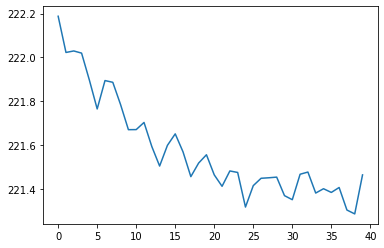

In [42]:
plt.plot(losses['test_loss'])

In [43]:
generation_testing(frozen_french_vae, train_dataset.unique_word_list)

Context: 
mariane		 closest match: marciane

Context: a
alexane		 closest match: alexane
alexandre		 closest match: alex

Context: m
mariane		 closest match: marciane

Context: sim
simone		 closest match: simone



## French model

In [44]:
french_names = []
with open(NAMES_DIR / "french_names_no_accent.txt", "r") as f:
    for word in f:
        french_names.append(clean_word(word))
french_vae = AttentionVae.load("french_model")

split = 0.9
idx = int(len(french_names) * split)
np.random.seed(137)
np.random.shuffle(french_names)
train_french_names = french_names[:idx]
val_french_names = french_names[idx:]

raw_train_french_names = " ".join(train_french_names)
raw_val_french_names = " ".join(val_french_names)

train_dataset = CharDataset(raw_train_french_names, maxlen, chars=chars)
val_dataset = CharDataset(raw_val_french_names, maxlen, chars=chars)

idx=298
x, y, word = train_dataset[idx]
print("x: ",decode_word(x.numpy(), french_vae.itos))
print("y: ",decode_word(y.numpy(), french_vae.itos))
print("word :", decode_word(word.numpy(), french_vae.itos))


chars = list(french_vae.stoi.keys())
maxlen = french_vae.config.block_size

tconf = TrainerConfig(
    max_epochs=40,
    batch_size=256,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
    sample_freq=10000,
#     freeze_layers=tuple(list)
)
trainer = Trainer(french_vae, train_dataset, val_dataset, tconf,log_nearest_words=True)
losses = trainer.train()

data has 34421 characters, 47 unique.
data has 3750 characters, 47 unique.
x:  genest
y:  genest
word : genest


epoch 1) iter 0: train_loss 224.4823761, lr = 5.999922e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: irier                     	 closes match: iribert 
Sample: canantisse                	 closes match: ana 
Sample: chiron                    	 closes match: hilarion 
Sample: amenent                   	 closes match: ame 


epoch 1) iter 2: train_loss 225.4535065, lr = 5.998594e-04:   2%|▏         | 3/135 [00:02<03:35,  1.64s/it]

Sample: celinie                   	 closes match: celine 


epoch 1) iter 134: train_loss 221.5705261, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00,  9.97it/s]


Test loss: 222.18383280436197


epoch 2) iter 0: train_loss 222.2345276, lr = 2.971632e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: cartere                   	 closes match: arteme 
Sample: arida                     	 closes match: aida 
Sample: chirinne                  	 closes match: corinne 
Sample: lomorette                 	 closes match: lo 


epoch 2) iter 2: train_loss 222.8744202, lr = 2.901402e-04:   2%|▏         | 3/135 [00:02<03:44,  1.70s/it]

Sample: abers                     	 closes match: aubert 


epoch 2) iter 134: train_loss 222.2676697, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.92it/s]


Test loss: 222.03486022949218


epoch 3) iter 0: train_loss 223.1513977, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: shelide                   	 closes match: helidie 
Sample: caune                     	 closes match: capucine 
Sample: licena                    	 closes match: lina 
Sample: thianne                   	 closes match: anne 


epoch 3) iter 2: train_loss 222.5356140, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:26,  1.57s/it]

Sample: maudaste                  	 closes match: maud 


epoch 3) iter 134: train_loss 221.1328430, lr = 3.006754e-04: 100%|██████████| 135/135 [00:13<00:00, 10.04it/s]


Test loss: 222.0330037434896


epoch 4) iter 0: train_loss 221.7206268, lr = 3.041876e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: carimber                  	 closes match: bert 
Sample: ganon                     	 closes match: ano 
Sample: petan                     	 closes match: petra 
Sample: malio                     	 closes match: ali 


epoch 4) iter 2: train_loss 222.0920258, lr = 3.112098e-04:   2%|▏         | 3/135 [00:02<03:33,  1.62s/it]

Sample: gy                        	 closes match: angy 


epoch 4) iter 134: train_loss 222.6777649, lr = 5.999970e-04: 100%|██████████| 135/135 [00:13<00:00,  9.99it/s]


Test loss: 222.0788106282552


epoch 5) iter 0: train_loss 222.3203735, lr = 5.999606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: bendie                    	 closes match: ben 
Sample: anane                     	 closes match: agnane 
Sample: aleamine                  	 closes match: lea 
Sample: moin                      	 closes match: austremoine 


epoch 5) iter 2: train_loss 221.6984406, lr = 5.997645e-04:   2%|▏         | 3/135 [00:02<03:56,  1.79s/it]

Sample: lack                      	 closes match: thorlak 


epoch 5) iter 134: train_loss 222.8851166, lr = 2.979737e-04: 100%|██████████| 135/135 [00:13<00:00,  9.83it/s]


Test loss: 221.87674255371093


epoch 6) iter 0: train_loss 221.5662231, lr = 2.944616e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: guidina                   	 closes match: dina 
Sample: goundra                   	 closes match: dora 
Sample: syld                      	 closes match: sylvane 
Sample: joelves                   	 closes match: joel 


epoch 6) iter 2: train_loss 221.2637024, lr = 2.874403e-04:   2%|▏         | 3/135 [00:02<03:14,  1.48s/it]

Sample: catthe                    	 closes match: cathel 


epoch 6) iter 134: train_loss 221.3503723, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.15it/s]


Test loss: 221.77590738932292


epoch 7) iter 0: train_loss 222.1311035, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: giolien                   	 closes match: jolien 
Sample: leonchian                 	 closes match: ian 
Sample: eulea                     	 closes match: lea 
Sample: chrysseen                 	 closes match: chrystele 


epoch 7) iter 2: train_loss 220.8981323, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:56,  1.79s/it]

Sample: selbeds                   	 closes match: ed 


epoch 7) iter 134: train_loss 221.1533203, lr = 3.033772e-04: 100%|██████████| 135/135 [00:13<00:00,  9.82it/s]


Test loss: 221.84271138509115


epoch 8) iter 0: train_loss 221.4886475, lr = 3.068890e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: leopepo                   	 closes match: leo 
Sample: guelle                    	 closes match: gaelle 
Sample: lazanne                   	 closes match: anne 
Sample: gontad                    	 closes match: gond 


epoch 8) iter 2: train_loss 221.6516113, lr = 3.139092e-04:   2%|▏         | 3/135 [00:02<03:07,  1.42s/it]

Sample: auricel                   	 closes match: maurice 


epoch 8) iter 134: train_loss 222.1964569, lr = 5.999726e-04: 100%|██████████| 135/135 [00:13<00:00, 10.22it/s]


Test loss: 221.88031921386718


epoch 9) iter 0: train_loss 221.9499817, lr = 5.999046e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lyblond                   	 closes match: lo 
Sample: pistom                    	 closes match: tom 
Sample: brudol                    	 closes match: rudolf 
Sample: lina                      	 closes match: lina 


epoch 9) iter 2: train_loss 221.4474335, lr = 5.996453e-04:   2%|▏         | 3/135 [00:02<03:29,  1.59s/it]

Sample: leuma                     	 closes match: lea 


epoch 9) iter 134: train_loss 220.3925629, lr = 2.952721e-04: 100%|██████████| 135/135 [00:13<00:00, 10.02it/s]


Test loss: 221.65997823079428


epoch 10) iter 0: train_loss 221.5284271, lr = 2.917606e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: custharise                	 closes match: isea 
Sample: thabudine                 	 closes match: tudine 
Sample: myssiten                  	 closes match: siena 
Sample: tipheroce                 	 closes match: piero 


epoch 10) iter 2: train_loss 221.8128662, lr = 2.847415e-04:   2%|▏         | 3/135 [00:03<04:44,  2.15s/it]

Sample: clasouelle                	 closes match: ellen 


epoch 10) iter 134: train_loss 221.3608246, lr = 6.000000e-05: 100%|██████████| 135/135 [00:14<00:00,  9.45it/s]


Test loss: 221.6354553222656


epoch 11) iter 0: train_loss 221.4263306, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: bacil                     	 closes match: basile 
Sample: annaie                    	 closes match: anna 
Sample: vantom                    	 closes match: tom 
Sample: melia                     	 closes match: amelia 


epoch 11) iter 2: train_loss 221.4208679, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:45,  1.71s/it]

Sample: theophilna                	 closes match: theo 


epoch 11) iter 134: train_loss 223.0485382, lr = 3.060786e-04: 100%|██████████| 135/135 [00:13<00:00,  9.93it/s]


Test loss: 221.71308390299478


epoch 12) iter 0: train_loss 222.1394958, lr = 3.095897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: billic                    	 closes match: bill 
Sample: gildebeul                 	 closes match: gil 
Sample: marian                    	 closes match: marian 
Sample: lodia                     	 closes match: lo 


epoch 12) iter 2: train_loss 221.3630371, lr = 3.166075e-04:   2%|▏         | 3/135 [00:02<03:44,  1.70s/it]

Sample: neberien                  	 closes match: iwen 


epoch 12) iter 134: train_loss 221.7245331, lr = 5.999240e-04: 100%|██████████| 135/135 [00:13<00:00,  9.91it/s]


Test loss: 221.71621805826823


epoch 13) iter 0: train_loss 221.4847107, lr = 5.998243e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: savisenne                 	 closes match: sienne 
Sample: euliere                   	 closes match: erle 
Sample: marlic                    	 closes match: marick 
Sample: richae                    	 closes match: richarde 


epoch 13) iter 2: train_loss 221.2884827, lr = 5.995018e-04:   2%|▏         | 3/135 [00:02<03:45,  1.70s/it]

Sample: elise                     	 closes match: elise 


epoch 13) iter 134: train_loss 220.6235199, lr = 2.925708e-04: 100%|██████████| 135/135 [00:13<00:00,  9.90it/s]


Test loss: 221.60733032226562


epoch 14) iter 0: train_loss 221.9514160, lr = 2.890602e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: antay                     	 closes match: verohanta 
Sample: marin                     	 closes match: marin 
Sample: alexin                    	 closes match: alexina 
Sample: matau                     	 closes match: marta 


epoch 14) iter 2: train_loss 220.8672791, lr = 2.820438e-04:   2%|▏         | 3/135 [00:02<03:20,  1.52s/it]

Sample: lericin                   	 closes match: eric 


epoch 14) iter 134: train_loss 222.1074066, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.12it/s]


Test loss: 221.5497782389323


epoch 15) iter 0: train_loss 221.4111023, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: guilay                    	 closes match: gui 
Sample: melencili                 	 closes match: melen 
Sample: stesis                    	 closes match: stessy 
Sample: ropas                     	 closes match: roparz 


epoch 15) iter 2: train_loss 222.2157898, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:41,  1.68s/it]

Sample: punite                    	 closes match: itte 


epoch 15) iter 134: train_loss 221.2095795, lr = 3.087796e-04: 100%|██████████| 135/135 [00:13<00:00,  9.95it/s]


Test loss: 221.58065795898438


epoch 16) iter 0: train_loss 221.2411499, lr = 3.122897e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: babneus                   	 closes match: urs 
Sample: balisan                   	 closes match: balian 
Sample: crolaes                   	 closes match: ares 
Sample: alia                      	 closes match: alia 


epoch 16) iter 2: train_loss 221.6808167, lr = 3.193045e-04:   2%|▏         | 3/135 [00:02<03:29,  1.59s/it]

Sample: maelise                   	 closes match: maelis 


epoch 16) iter 134: train_loss 221.6534119, lr = 5.998510e-04: 100%|██████████| 135/135 [00:13<00:00, 10.02it/s]


Test loss: 221.69241536458333


epoch 17) iter 0: train_loss 221.7555084, lr = 5.997197e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: runabyl                   	 closes match: ruby 
Sample: clron                     	 closes match: claroun 
Sample: annye                     	 closes match: ann 
Sample: ethelia                   	 closes match: lia 


epoch 17) iter 2: train_loss 221.5010681, lr = 5.993340e-04:   2%|▏         | 3/135 [00:02<03:19,  1.51s/it]

Sample: leoba                     	 closes match: leo 


epoch 17) iter 134: train_loss 221.5653534, lr = 2.898702e-04: 100%|██████████| 135/135 [00:13<00:00, 10.13it/s]


Test loss: 221.59099629720052


epoch 18) iter 0: train_loss 221.6926270, lr = 2.863607e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aremine                   	 closes match: remi 
Sample: siganne                   	 closes match: anne 
Sample: cypr                      	 closes match: cypriane 
Sample: evann                     	 closes match: ann 


epoch 18) iter 2: train_loss 221.3474426, lr = 2.793476e-04:   2%|▏         | 3/135 [00:02<03:21,  1.53s/it]

Sample: lerega                    	 closes match: leria 


epoch 18) iter 134: train_loss 220.7893066, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.11it/s]


Test loss: 221.49289245605468


epoch 19) iter 0: train_loss 220.8811493, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: narilein                  	 closes match: leina 
Sample: sybrarie                  	 closes match: rite 
Sample: garturie                  	 closes match: uriel 
Sample: jachen                    	 closes match: jacek 


epoch 19) iter 2: train_loss 221.0309448, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:37,  1.65s/it]

Sample: fresine                   	 closes match: resi 


epoch 19) iter 134: train_loss 220.6881866, lr = 3.114798e-04: 100%|██████████| 135/135 [00:13<00:00,  9.98it/s]


Test loss: 221.53829854329427


epoch 20) iter 0: train_loss 221.4964600, lr = 3.149887e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ale                       	 closes match: valerien 
Sample: maelva                    	 closes match: maela 
Sample: narina                    	 closes match: marina 
Sample: erwan                     	 closes match: erwan 


epoch 20) iter 2: train_loss 220.7243042, lr = 3.219998e-04:   2%|▏         | 3/135 [00:02<03:37,  1.65s/it]

Sample: sividne                   	 closes match: ivi 


epoch 20) iter 134: train_loss 220.6403046, lr = 5.997537e-04: 100%|██████████| 135/135 [00:13<00:00,  9.99it/s]


Test loss: 221.64080708821615


epoch 21) iter 0: train_loss 221.6834412, lr = 5.995908e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aurahin                   	 closes match: aura 
Sample: salda                     	 closes match: alda 
Sample: ermin                     	 closes match: ermin 
Sample: arbin                     	 closes match: gabin 


epoch 21) iter 2: train_loss 221.6035767, lr = 5.991420e-04:   2%|▏         | 3/135 [00:02<03:27,  1.58s/it]

Sample: malis                     	 closes match: maelis 


epoch 21) iter 134: train_loss 221.6382141, lr = 2.871704e-04: 100%|██████████| 135/135 [00:13<00:00, 10.06it/s]


Test loss: 221.50025431315103


epoch 22) iter 0: train_loss 220.7428589, lr = 2.836622e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: theline                   	 closes match: lin 
Sample: therve                    	 closes match: herve 
Sample: eusteline                 	 closes match: lin 
Sample: saratia                   	 closes match: tia 


epoch 22) iter 2: train_loss 221.5593719, lr = 2.766531e-04:   2%|▏         | 3/135 [00:02<03:29,  1.59s/it]

Sample: leavine                   	 closes match: lea 


epoch 22) iter 134: train_loss 221.4313049, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.04it/s]


Test loss: 221.42351175944012


epoch 23) iter 0: train_loss 221.1954498, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: elias                     	 closes match: elias 
Sample: turislaie                 	 closes match: lalie 
Sample: may                       	 closes match: may 
Sample: maire                     	 closes match: mai 


epoch 23) iter 2: train_loss 221.4450378, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<04:12,  1.91s/it]

Sample: jana                      	 closes match: jana 


epoch 23) iter 134: train_loss 221.0827942, lr = 3.141791e-04: 100%|██████████| 135/135 [00:13<00:00,  9.73it/s]


Test loss: 221.40618387858072


epoch 24) iter 0: train_loss 221.4229126, lr = 3.176865e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: clatiacine                	 closes match: tia 
Sample: floris                    	 closes match: floris 
Sample: mantis                    	 closes match: mattis 
Sample: ayrna                     	 closes match: mayna 


epoch 24) iter 2: train_loss 220.9468994, lr = 3.246934e-04:   2%|▏         | 3/135 [00:02<03:51,  1.75s/it]

Sample: suziza                    	 closes match: izia 


epoch 24) iter 134: train_loss 221.2818451, lr = 5.996320e-04: 100%|██████████| 135/135 [00:13<00:00,  9.85it/s]


Test loss: 221.45008748372396


epoch 25) iter 0: train_loss 221.3096313, lr = 5.994376e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: maranaia                  	 closes match: mara 
Sample: sambe                     	 closes match: sam 
Sample: gaseran                   	 closes match: german 
Sample: dina                      	 closes match: dina 


epoch 25) iter 2: train_loss 221.0548096, lr = 5.989256e-04:   2%|▏         | 3/135 [00:02<03:43,  1.69s/it]

Sample: allon                     	 closes match: lo 


epoch 25) iter 134: train_loss 221.4103699, lr = 2.844716e-04: 100%|██████████| 135/135 [00:13<00:00,  9.90it/s]


Test loss: 221.44852091471355


epoch 26) iter 0: train_loss 220.3719177, lr = 2.809652e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: salana                    	 closes match: alan 
Sample: loeisil                   	 closes match: lo 
Sample: marandet                  	 closes match: mara 
Sample: rosma                     	 closes match: rosa 


epoch 26) iter 2: train_loss 220.9260864, lr = 2.739605e-04:   2%|▏         | 3/135 [00:02<03:25,  1.56s/it]

Sample: annia                     	 closes match: ann 


epoch 26) iter 134: train_loss 221.1879730, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.08it/s]


Test loss: 221.36097005208333


epoch 27) iter 0: train_loss 220.8679810, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: margarie                  	 closes match: margaret 
Sample: jeano                     	 closes match: ano 
Sample: jan                       	 closes match: jan 
Sample: clatre                    	 closes match: clar 


epoch 27) iter 2: train_loss 220.5566711, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:41,  1.68s/it]

Sample: abrard                    	 closes match: ebrard 


epoch 27) iter 134: train_loss 219.7893219, lr = 3.168773e-04: 100%|██████████| 135/135 [00:13<00:00,  9.93it/s]


Test loss: 221.37100016276042


epoch 28) iter 0: train_loss 221.1926270, lr = 3.203828e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: firettera                 	 closes match: erna 
Sample: mery                      	 closes match: meryem 
Sample: alina                     	 closes match: galina 
Sample: mata                      	 closes match: marta 


epoch 28) iter 2: train_loss 221.0615234, lr = 3.273850e-04:   2%|▏         | 3/135 [00:02<04:16,  1.95s/it]

Sample: syntaine                  	 closes match: aigne 


epoch 28) iter 134: train_loss 220.4591217, lr = 5.994861e-04: 100%|██████████| 135/135 [00:13<00:00,  9.68it/s]


Test loss: 221.5432159423828


epoch 29) iter 0: train_loss 220.6960754, lr = 5.992601e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mary                      	 closes match: maryanick 
Sample: fulcesi                   	 closes match: luce 
Sample: pascolite                 	 closes match: pascaline 
Sample: evarian                   	 closes match: ian 


epoch 29) iter 2: train_loss 221.0626068, lr = 5.986851e-04:   2%|▏         | 3/135 [00:02<03:47,  1.72s/it]

Sample: nanik                     	 closes match: anika 


epoch 29) iter 134: train_loss 221.2553101, lr = 2.817741e-04: 100%|██████████| 135/135 [00:13<00:00,  9.90it/s]


Test loss: 221.39969482421876


epoch 30) iter 0: train_loss 220.9420013, lr = 2.782696e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: andrick                   	 closes match: rick 
Sample: cynne                     	 closes match: cheyenne 
Sample: junia                     	 closes match: juana 
Sample: ancoa                     	 closes match: manoa 


epoch 30) iter 2: train_loss 221.2481689, lr = 2.712700e-04:   2%|▏         | 3/135 [00:02<03:18,  1.50s/it]

Sample: brigi                     	 closes match: brigitte 


epoch 30) iter 134: train_loss 220.7804718, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.13it/s]


Test loss: 221.34860127766927


epoch 31) iter 0: train_loss 221.0045929, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: aymel                     	 closes match: aymeline 
Sample: conoul                    	 closes match: consolata 
Sample: stershin                  	 closes match: asterine 
Sample: lucevie                   	 closes match: luc 


epoch 31) iter 2: train_loss 220.5299683, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:24,  1.55s/it]

Sample: liena                     	 closes match: lina 


epoch 31) iter 134: train_loss 221.5934296, lr = 3.195741e-04: 100%|██████████| 135/135 [00:13<00:00, 10.10it/s]


Test loss: 221.38641459147135


epoch 32) iter 0: train_loss 221.0930176, lr = 3.230775e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gourgine                  	 closes match: georgine 
Sample: aumuniane                 	 closes match: ian 
Sample: aliphrsia                 	 closes match: ali 
Sample: josena                    	 closes match: jos 


epoch 32) iter 2: train_loss 221.0667877, lr = 3.300744e-04:   2%|▏         | 3/135 [00:02<04:24,  2.01s/it]

Sample: jacquella                 	 closes match: ella 


epoch 32) iter 134: train_loss 221.6111145, lr = 5.993159e-04: 100%|██████████| 135/135 [00:14<00:00,  9.62it/s]


Test loss: 221.43326009114583


epoch 33) iter 0: train_loss 220.5759125, lr = 5.990583e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: scevie                    	 closes match: evie 
Sample: angelline                 	 closes match: angeline 
Sample: fabile                    	 closes match: fabien 
Sample: mouctine                  	 closes match: toine 


epoch 33) iter 2: train_loss 221.3845978, lr = 5.984203e-04:   2%|▏         | 3/135 [00:02<03:53,  1.77s/it]

Sample: audule                    	 closes match: gudule 


epoch 33) iter 134: train_loss 221.9626465, lr = 2.790781e-04: 100%|██████████| 135/135 [00:13<00:00,  9.85it/s]


Test loss: 221.29320271809897


epoch 34) iter 0: train_loss 220.3540649, lr = 2.755758e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: tylane                    	 closes match: thylane 
Sample: ewann                     	 closes match: erwann 
Sample: christeba                 	 closes match: chris 
Sample: elyne                     	 closes match: ellyne 


epoch 34) iter 2: train_loss 220.9222260, lr = 2.685818e-04:   2%|▏         | 3/135 [00:02<03:56,  1.79s/it]

Sample: lexa                      	 closes match: lexane 


epoch 34) iter 134: train_loss 220.6655579, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00,  9.85it/s]


Test loss: 221.1817637125651


epoch 35) iter 0: train_loss 220.3544006, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: atheair                   	 closes match: thea 
Sample: marilles                  	 closes match: maurille 
Sample: raph                      	 closes match: seraphie 
Sample: decte                     	 closes match: dieter 


epoch 35) iter 2: train_loss 220.6741028, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:35,  1.63s/it]

Sample: anton                     	 closes match: anton 


epoch 35) iter 134: train_loss 220.3271484, lr = 3.222693e-04: 100%|██████████| 135/135 [00:13<00:00, 10.01it/s]


Test loss: 221.42804260253905


epoch 36) iter 0: train_loss 221.1527100, lr = 3.257703e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: mormettine                	 closes match: ines 
Sample: coran                     	 closes match: goran 
Sample: conole                    	 closes match: oleg 
Sample: andreda                   	 closes match: andrea 


epoch 36) iter 2: train_loss 221.2214508, lr = 3.327613e-04:   2%|▏         | 3/135 [00:02<03:38,  1.65s/it]

Sample: errmane                   	 closes match: germane 


epoch 36) iter 134: train_loss 220.8982544, lr = 5.991214e-04: 100%|██████████| 135/135 [00:13<00:00,  9.97it/s]


Test loss: 221.4509521484375


epoch 37) iter 0: train_loss 220.8845520, lr = 5.988323e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: chrysenne                 	 closes match: sienne 
Sample: raissa                    	 closes match: raissa 
Sample: mathanee                  	 closes match: noee 
Sample: anaelle                   	 closes match: anaelle 


epoch 37) iter 2: train_loss 220.7748108, lr = 5.981313e-04:   2%|▏         | 3/135 [00:02<03:58,  1.81s/it]

Sample: christora                 	 closes match: chris 


epoch 37) iter 134: train_loss 220.4975433, lr = 2.763838e-04: 100%|██████████| 135/135 [00:13<00:00,  9.84it/s]


Test loss: 221.36153869628907


epoch 38) iter 0: train_loss 220.7894592, lr = 2.728841e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: velant                    	 closes match: venant 
Sample: bertille                  	 closes match: bertille 
Sample: eliodie                   	 closes match: elodie 
Sample: arote                     	 closes match: marotte 


epoch 38) iter 2: train_loss 220.8403625, lr = 2.658962e-04:   2%|▏         | 3/135 [00:02<03:26,  1.56s/it]

Sample: cudine                    	 closes match: claudine 


epoch 38) iter 134: train_loss 221.1203308, lr = 6.000000e-05: 100%|██████████| 135/135 [00:13<00:00, 10.07it/s]


Test loss: 221.24722900390626


epoch 39) iter 0: train_loss 220.9147949, lr = 6.000000e-05:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: jana                      	 closes match: jana 
Sample: maricop                   	 closes match: marco 
Sample: egiada                    	 closes match: ada 
Sample: lora                      	 closes match: lora 


epoch 39) iter 2: train_loss 220.5468903, lr = 6.000000e-05:   2%|▏         | 3/135 [00:02<03:44,  1.70s/it]

Sample: girica                    	 closes match: iria 


epoch 39) iter 134: train_loss 220.9903717, lr = 3.249627e-04: 100%|██████████| 135/135 [00:13<00:00,  9.95it/s]


Test loss: 221.3573954264323


epoch 40) iter 0: train_loss 220.9487000, lr = 3.284610e-04:   0%|          | 0/135 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: lillere                   	 closes match: lilee 
Sample: leodorin                  	 closes match: leo 
Sample: mayare                    	 closes match: aya 
Sample: maurisie                  	 closes match: maur 


epoch 40) iter 2: train_loss 221.1856689, lr = 3.354456e-04:   2%|▏         | 3/135 [00:02<03:35,  1.63s/it]

Sample: jaulisse                  	 closes match: lis 


epoch 40) iter 134: train_loss 221.3414001, lr = 5.989027e-04: 100%|██████████| 135/135 [00:13<00:00, 10.01it/s]


Test loss: 221.4162394205729


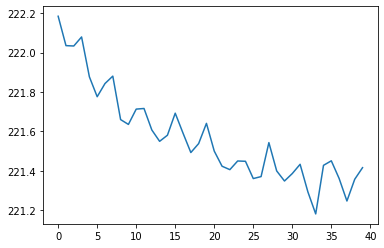

In [45]:
plt.plot(losses['test_loss'])

In [46]:
generation_testing(french_vae, train_dataset.unique_word_list)

Context: 
alexane		 closest match: alexane
albert		 closest match: albert

Context: a
alexane		 closest match: alexane
albert		 closest match: albert

Context: m
mariane		 closest match: marciane

Context: sim
simphorie		 closest match: symphorine



In [77]:
generation_testing(
    french_vae,
    train_dataset.unique_word_list,
    method="smart",
    sample=True,
    top_k=5,
    temperature=1.0,
)

Context: 
seranne             		 closest match: anne
matude              		 closest match: maude
aureas              		 closest match: aurea
marya               		 closest match: maryanick
aubastisla          		 closest match: rastislav
catin               		 closest match: cantien
lisee               		 closest match: elisee
annane              		 closest match: anna
chryson             		 closest match: chrysogone
marylina            		 closest match: lin
amath               		 closest match: mathe
lauren              		 closest match: lauren
marys               		 closest match: maryse
lamen               		 closest match: ame
mary                		 closest match: maryanick
amariso             		 closest match: damaris
micka               		 closest match: mickaele
sanike              		 closest match: sandie
myonn               		 closest match: yoann
mico                		 closest match: mick
marcel              		 closest match: marcel
leon                		 closest match: leon
s

## Next

# Junk

In [29]:
losses = []
loader = DataLoader(
            val_dataset,
            shuffle=False,
            pin_memory=True,
            batch_size=128
        )
for x, y, word in loader:
    with torch.no_grad():
        x = x.to(frozen_wiki_vae.device)
        y = y.to(trainer.device)
        word = word.to(frozen_wiki_vae.device)
        logits, loss_dict = frozen_wiki_vae.model(x, y, word, training=True)

        losses.append(loss_dict["loss"])
        
    

ModuleAttributeError: 'AttentionVae' object has no attribute 'device'

In [ ]:
french_vae = AttentionVae.load("french_model")
tconf = TrainerConfig(
    max_epochs=10,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
)
trainer = Trainer(french_vae, train_dataset, None, tconf)
losses = trainer.train()

In [15]:
from fuzzywuzzy import process

In [28]:
train_dataset.word_list

In [29]:
print(french_names)

match = process.extract("list", french_names, limit=2)

In [23]:
match

In [84]:
config = GPTConfig(train_dataset.vocab_size, maxlen, n_layer=2, n_head=4, n_embd=64)
plain_vae = AttentionVae(config)
tconf = TrainerConfig(
    max_epochs=10,
    batch_size=128,
    learning_rate=6e-4,
    lr_decay=True,
    warmup_tokens=128 * 20,
    final_tokens=2 * len(train_dataset) * maxlen,
    num_workers=4,
)
trainer = Trainer(plain_vae, train_dataset, None, tconf)
losses = trainer.train()

number of parameters: 851904


  0%|          | 0/299 [00:00<?, ?it/s]/home/simon/code/namegen/avae/src/avae/trainer.py:101: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  self.model.parameters(), self.config.grad_norm_clip
epoch 1) iter 0: train_loss 567.6885986, lr = 5.999998e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample:  éà                         	 Closest match is aanor
Sample: i-ànwcg                     	 Closest match is inigo


Sample:  àöoöcqüàöà à               	 Closest match is aliocha
Sample:                             	 Closest match is aanor


epoch 1) iter 3: train_loss 455.8023376, lr = 5.999564e-04:   1%|          | 3/299 [00:01<05:53,  1.20s/it]

Sample: 'iqöi                       	 Closest match is aaricia


epoch 1) iter 298: train_loss 224.3321991, lr = 3.006089e-04: 100%|██████████| 299/299 [00:17<00:00, 17.15it/s]
epoch 2) iter 0: train_loss 225.4807281, lr = 2.990257e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ale                         	 Closest match is aleaume
Sample: paleoia                     	 Closest match is alexia


Sample: orito                       	 Closest match is aristote
Sample:                             	 Closest match is aanor


epoch 2) iter 3: train_loss 224.8954773, lr = 2.942763e-04:   1%|          | 3/299 [00:02<08:04,  1.64s/it]

Sample: erinno                      	 Closest match is zeferino


epoch 2) iter 298: train_loss 226.9024658, lr = 6.000000e-05: 100%|██████████| 299/299 [00:17<00:00, 16.63it/s]
epoch 3) iter 0: train_loss 223.4640198, lr = 6.000000e-05:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ginili                      	 Closest match is quintilien
Sample: guente                      	 Closest match is guenaelle
Sample: lbarero                     	 Closest match is alberto
Sample: maninta                     	 Closest match is anita


epoch 3) iter 3: train_loss 223.3650513, lr = 6.000000e-05:   1%|          | 3/299 [00:02<08:39,  1.75s/it]

Sample: grone                       	 Closest match is geronce


epoch 3) iter 298: train_loss 221.9121094, lr = 3.006089e-04: 100%|██████████| 299/299 [00:18<00:00, 16.48it/s]
epoch 4) iter 0: train_loss 223.3574066, lr = 3.021922e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: sasidrc                     	 Closest match is said
Sample: lacirtino                   	 Closest match is tino
Sample: shrieldrnde                 	 Closest match is hildebrande
Sample: cagurtin                    	 Closest match is augustin


epoch 4) iter 3: train_loss 222.5893860, lr = 3.069414e-04:   1%|          | 3/299 [00:03<10:53,  2.21s/it]

Sample: stlo                        	 Closest match is aristote


epoch 4) iter 298: train_loss 223.5995789, lr = 5.999975e-04: 100%|██████████| 299/299 [00:18<00:00, 15.81it/s]
epoch 5) iter 0: train_loss 223.7321777, lr = 5.999869e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: losta                       	 Closest match is lossa
Sample: cymie                       	 Closest match is cyrielle
Sample: jelloeniinon                	 Closest match is ellen
Sample: adodener                    	 Closest match is ode


epoch 5) iter 3: train_loss 223.0262756, lr = 5.999050e-04:   1%|          | 3/299 [00:03<11:24,  2.31s/it]

Sample: jora                        	 Closest match is joran


epoch 5) iter 298: train_loss 223.2532806, lr = 2.981732e-04: 100%|██████████| 299/299 [00:19<00:00, 15.68it/s]
epoch 6) iter 0: train_loss 223.5447083, lr = 2.965900e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: matau                       	 Closest match is amata
Sample: esian                       	 Closest match is elian
Sample: aleunse                     	 Closest match is arlene
Sample: gicia                       	 Closest match is gilia


epoch 6) iter 3: train_loss 222.6663055, lr = 2.918411e-04:   1%|          | 3/299 [00:02<09:46,  1.98s/it]

Sample: edrma                       	 Closest match is edma


epoch 6) iter 298: train_loss 217.3303680, lr = 6.000000e-05: 100%|██████████| 299/299 [00:18<00:00, 16.16it/s]
epoch 7) iter 0: train_loss 222.6403198, lr = 6.000000e-05:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: ansare                      	 Closest match is anskar
Sample: emand                       	 Closest match is emiland
Sample: sialle                      	 Closest match is austregisille
Sample: macirenne                   	 Closest match is irene


epoch 7) iter 3: train_loss 223.4590149, lr = 6.000000e-05:   1%|          | 3/299 [00:02<09:40,  1.96s/it]

Sample: elisiane                    	 Closest match is eliane


epoch 7) iter 298: train_loss 223.3740845, lr = 3.030447e-04: 100%|██████████| 299/299 [00:18<00:00, 16.20it/s]
epoch 8) iter 0: train_loss 222.2140503, lr = 3.046278e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: cleerine                    	 Closest match is cedrine
Sample: mailinnite                  	 Closest match is miline
Sample: guerttia                    	 Closest match is tia
Sample: saioldine                   	 Closest match is soline


epoch 8) iter 3: train_loss 222.3113251, lr = 3.093762e-04:   1%|          | 3/299 [00:02<09:20,  1.89s/it]

Sample: thann                       	 Closest match is samthann


epoch 8) iter 298: train_loss 220.3882141, lr = 5.999778e-04: 100%|██████████| 299/299 [00:18<00:00, 16.23it/s]
epoch 9) iter 0: train_loss 221.4678802, lr = 5.999543e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: gennediere                  	 Closest match is genevieve
Sample: lera                        	 Closest match is wallerand
Sample: legoni                      	 Closest match is leonie
Sample: londu                       	 Closest match is londa


epoch 9) iter 3: train_loss 223.1580200, lr = 5.998338e-04:   1%|          | 3/299 [00:03<10:56,  2.22s/it]

Sample: corn                        	 Closest match is cornaline


epoch 9) iter 298: train_loss 224.4233398, lr = 2.957375e-04: 100%|██████████| 299/299 [00:18<00:00, 15.83it/s]
epoch 10) iter 0: train_loss 221.9709015, lr = 2.941545e-04:   0%|          | 0/299 [00:00<?, ?it/s]

Iteration 0 samples:
Sample: natle                       	 Closest match is anatole
Sample: noass                       	 Closest match is thomassia
Sample: maudian                     	 Closest match is ian
Sample: graidole                    	 Closest match is agricole


epoch 10) iter 3: train_loss 223.1546631, lr = 2.894066e-04:   1%|          | 3/299 [00:02<09:06,  1.85s/it]

Sample: eliana                      	 Closest match is eliana


epoch 10) iter 298: train_loss 220.4730225, lr = 6.000000e-05: 100%|██████████| 299/299 [00:18<00:00, 16.31it/s]


In [82]:
train_dataset.block_size

26

In [ ]:
print("plain")
print()
initial_context = "sam"
outputs = generate_samples(initial_context, plain_vae)
for out in outputs:
    print(out)
print()

print("wiki")
print()
initial_context = "sam"
outputs = generate_samples(initial_context, wiki_vae)
for out in outputs:
    print(out)
print()

print("french")
print()
initial_context = "samanth"
outputs = generate_samples(initial_context, french_vae)
for out in outputs:
    print(out)
print()

In [96]:
process.extract("samantha", french_names)

[('samantha', 100), ('sam', 90), ('amata', 77), ('thao', 77), ('thea', 77)]